6
Processing data for conference: NeurIPS
Processing data for conference: ICLR
Processing data for conference: ICML
Processing data for conference: NLP
Processing data for conference: CV
Processing data for conference: InterSpeech


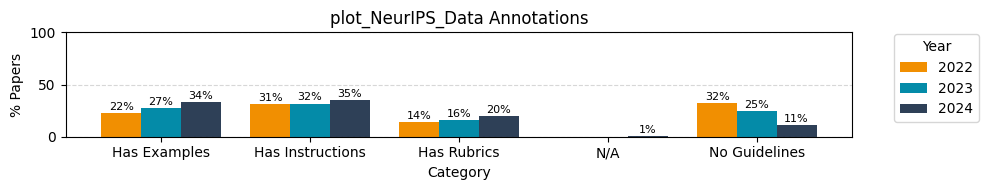

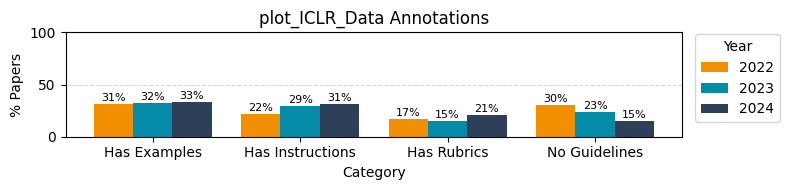

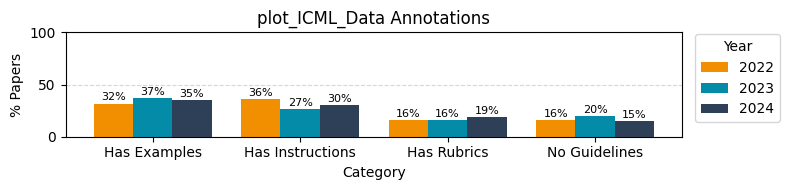

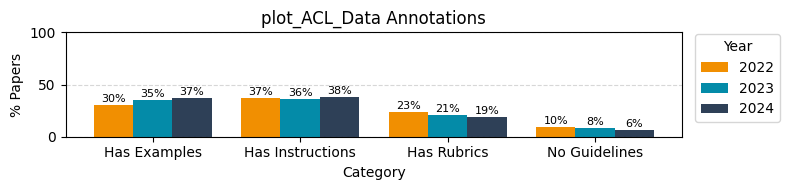

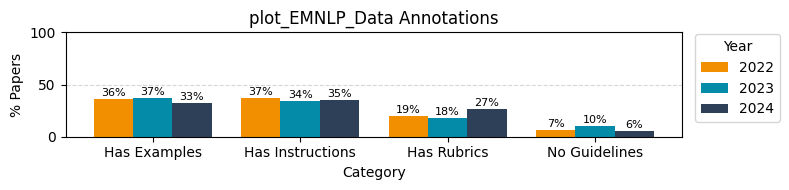

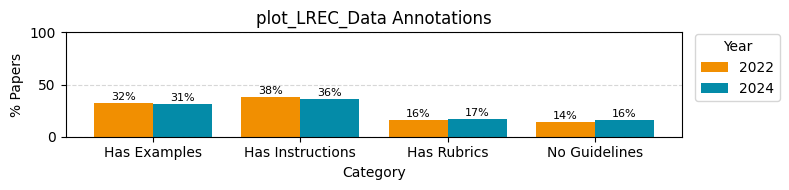

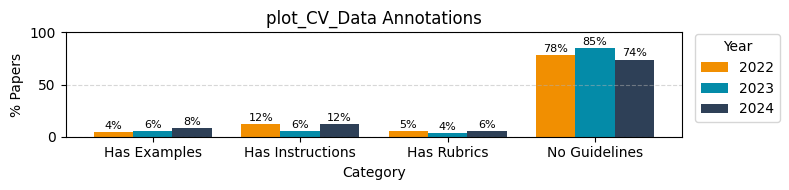

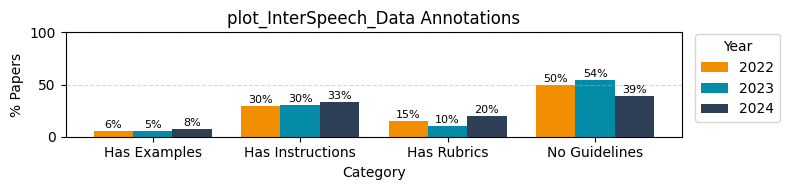

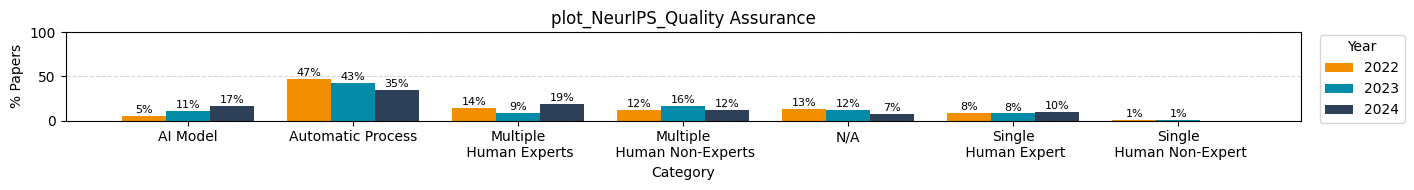

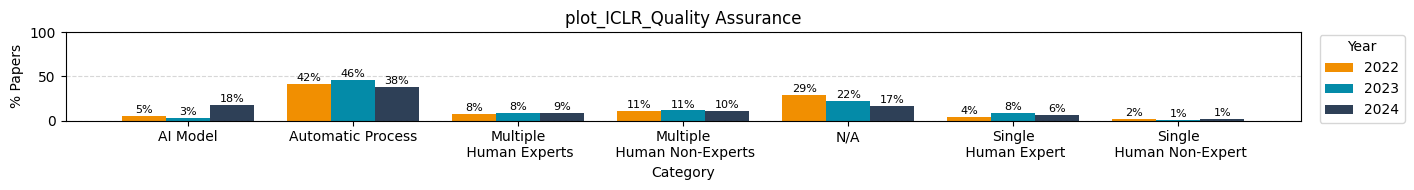

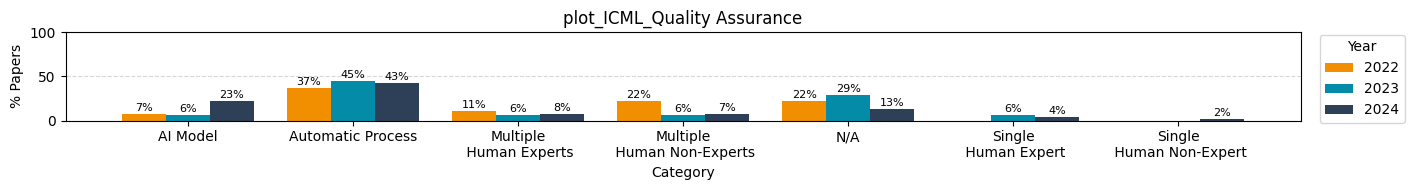

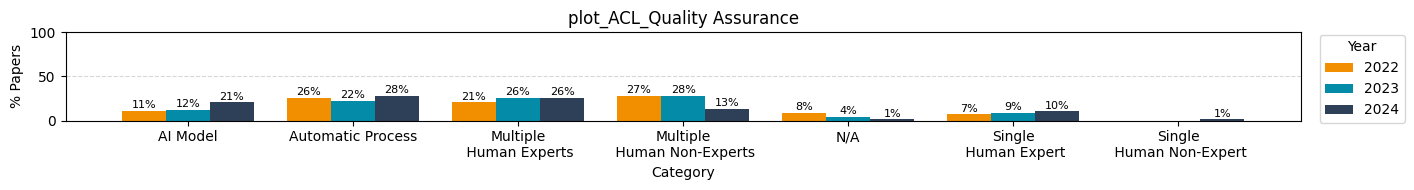

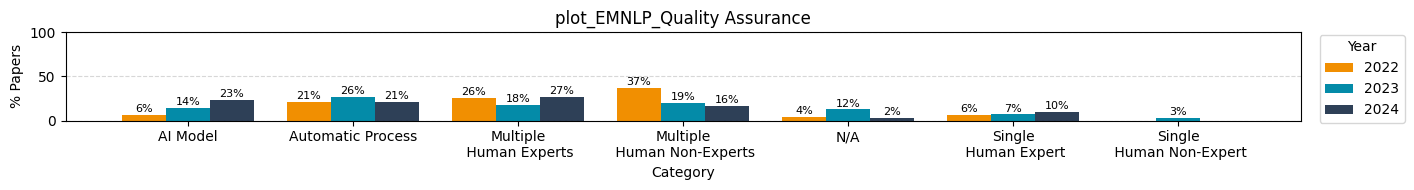

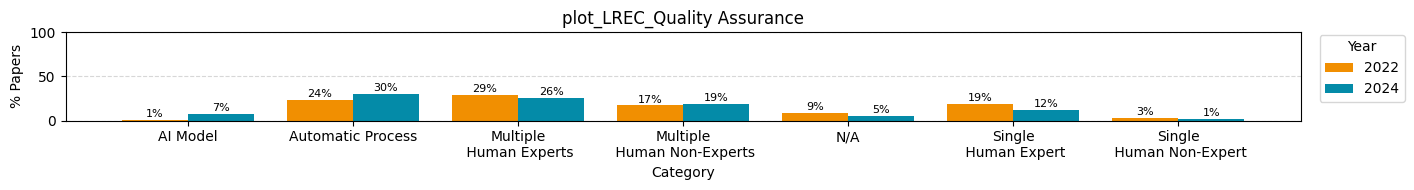

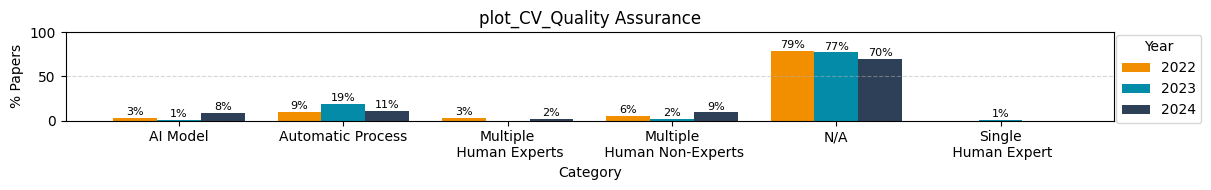

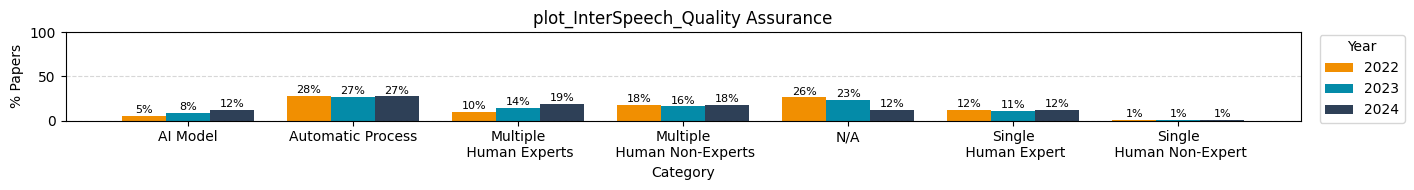

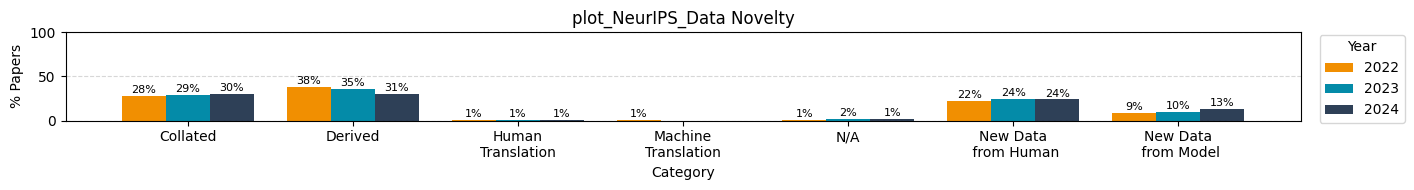

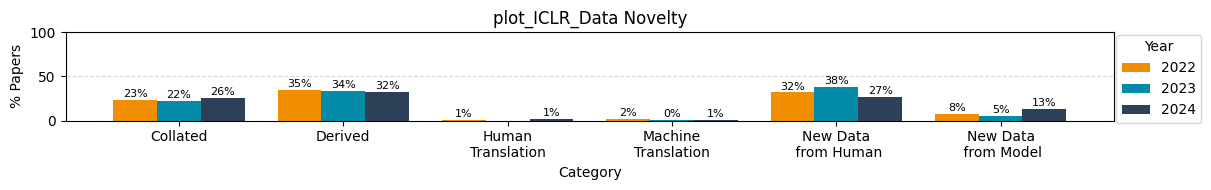

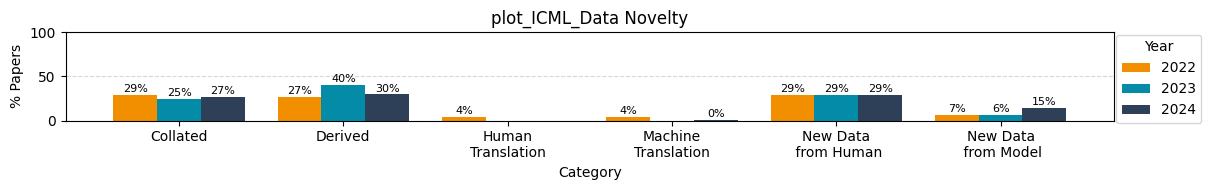

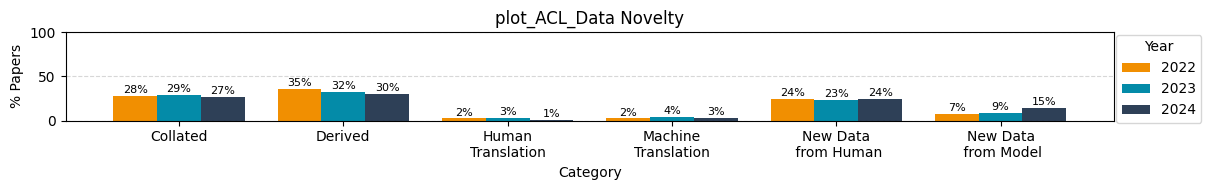

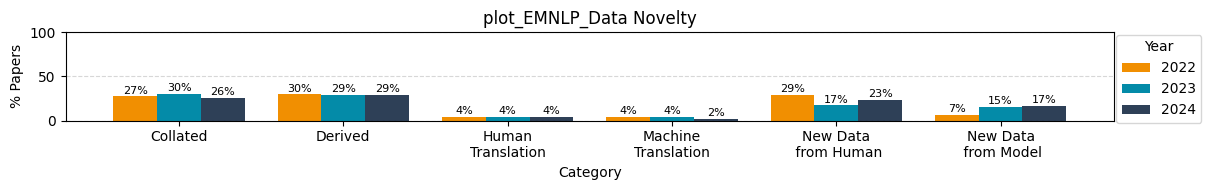

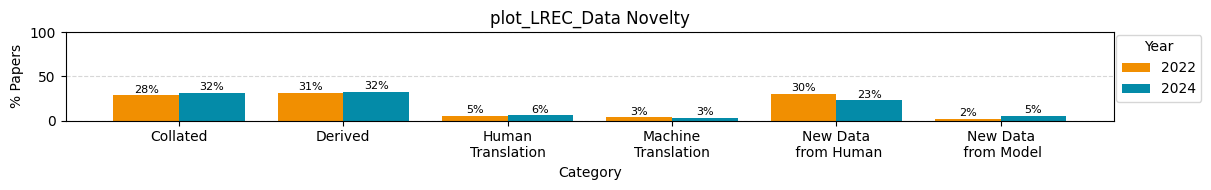

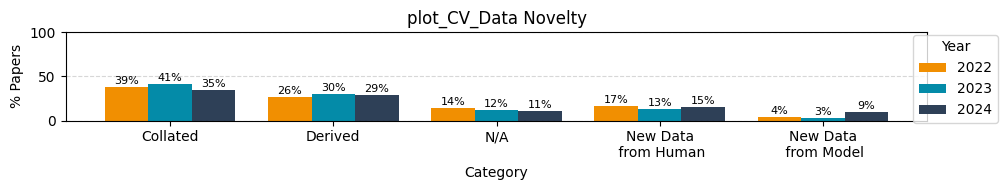

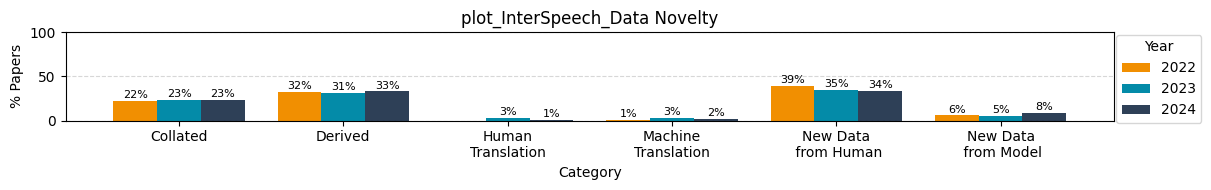

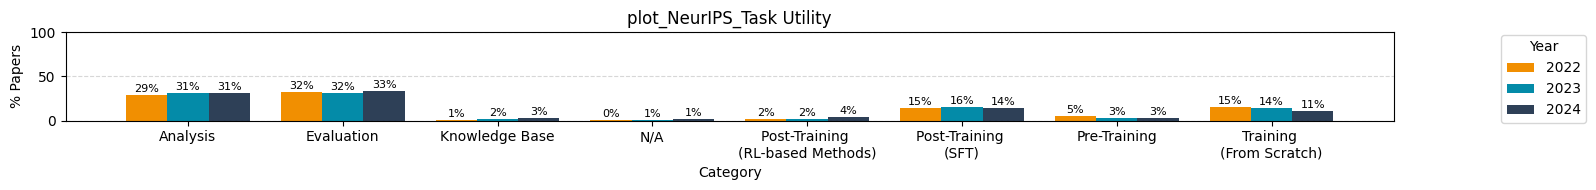

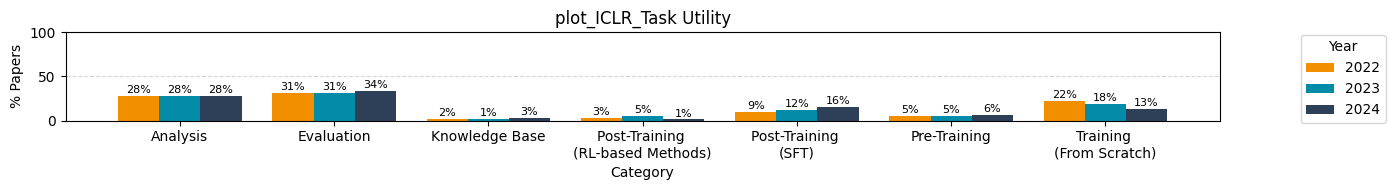

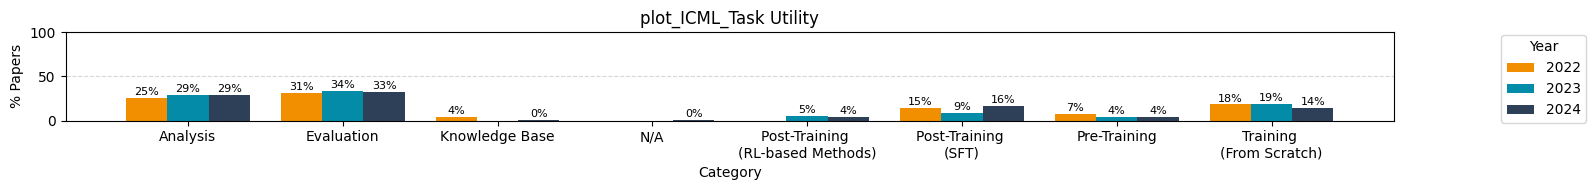

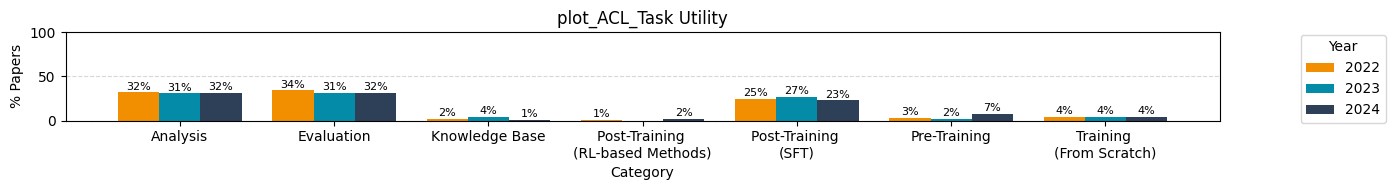

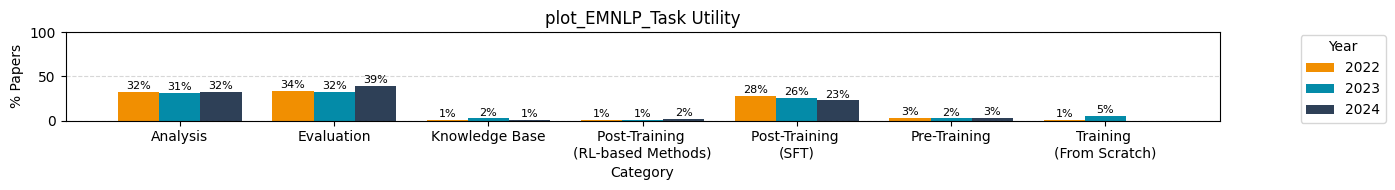

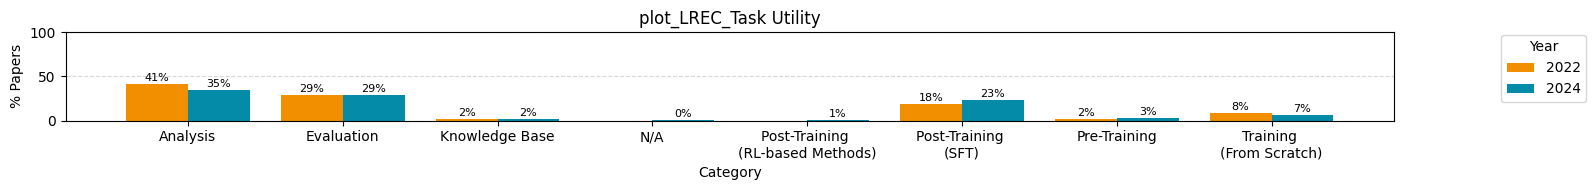

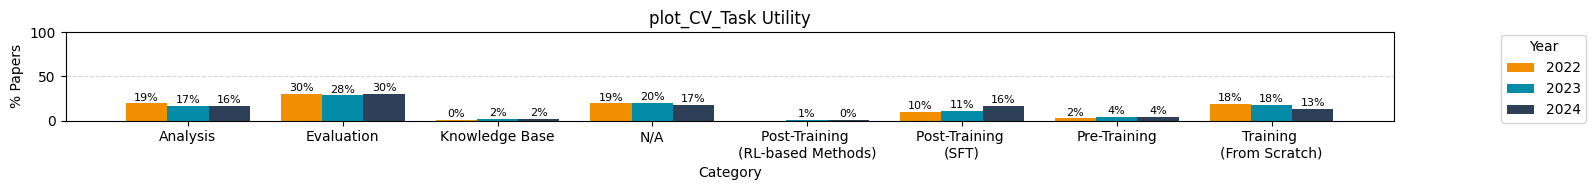

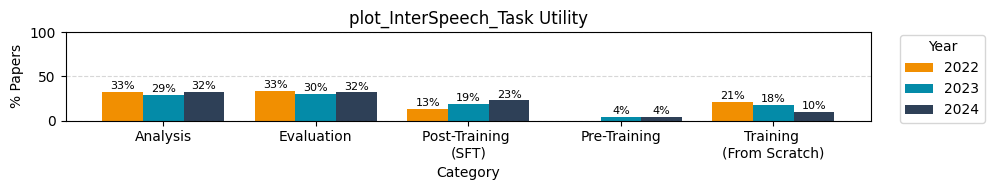

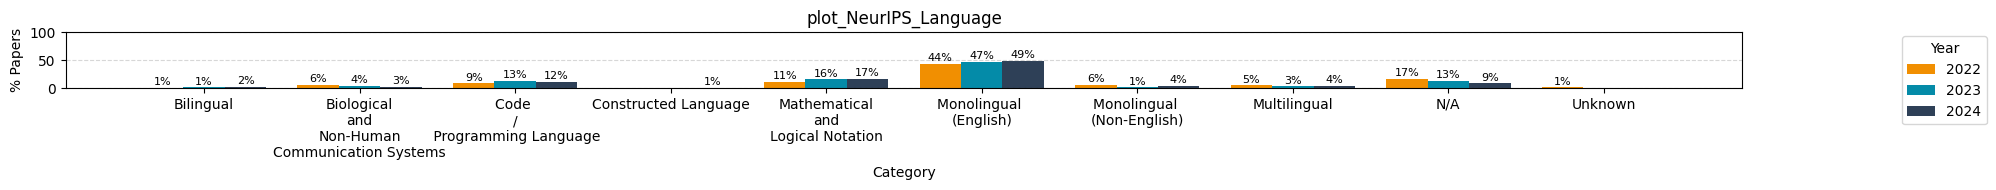

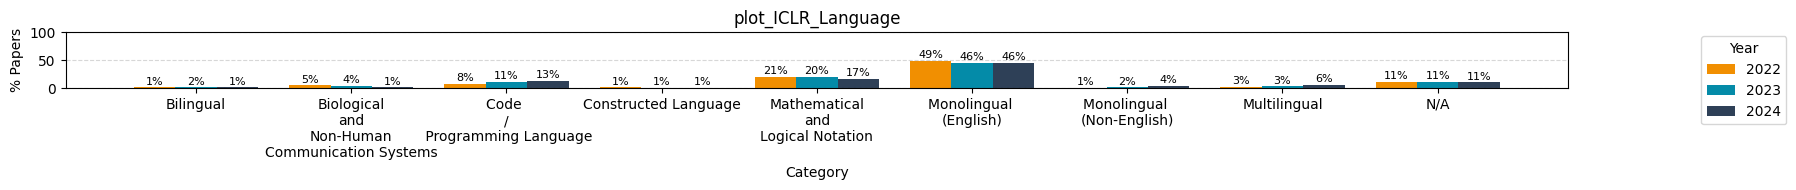

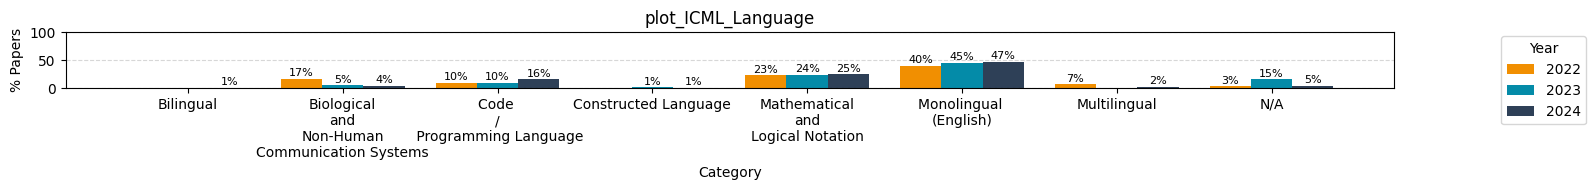

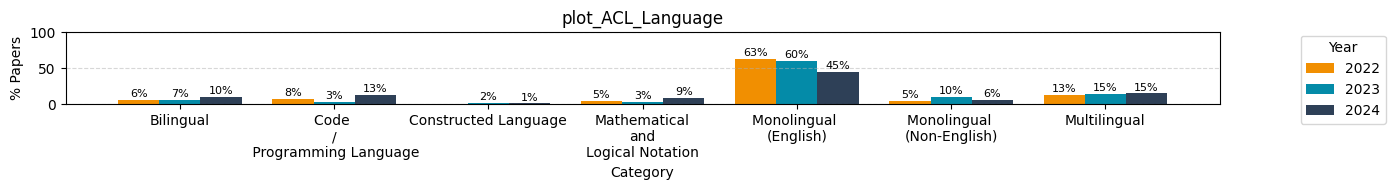

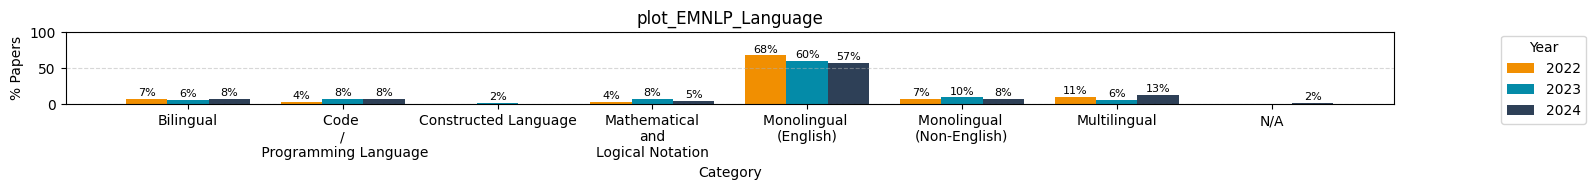

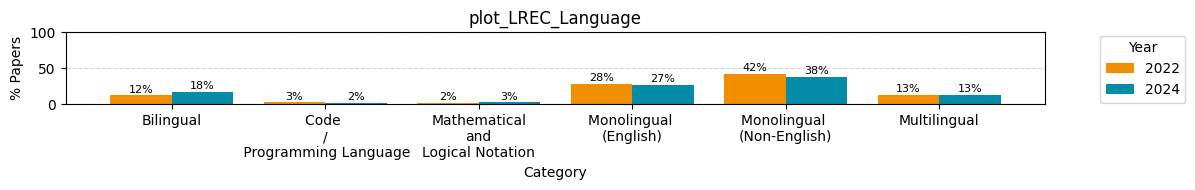

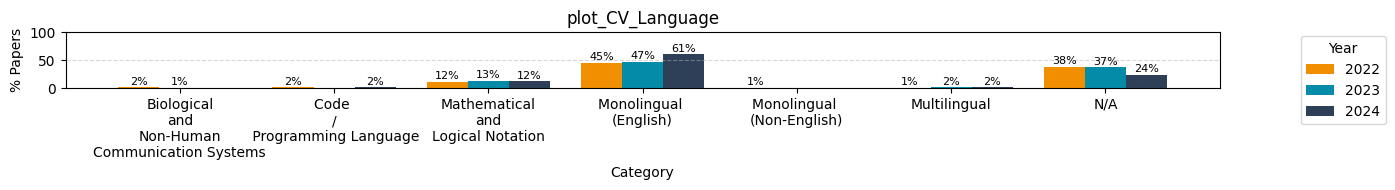

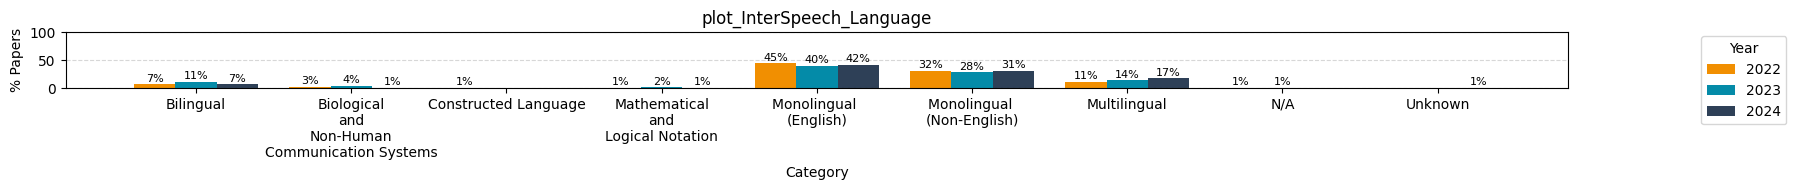

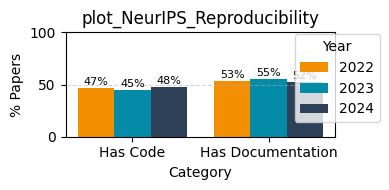

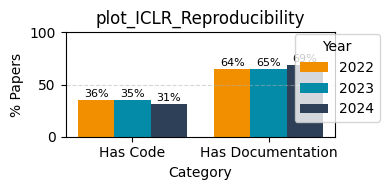

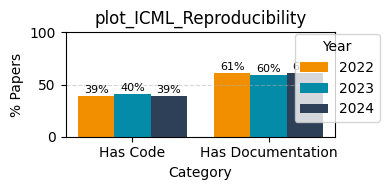

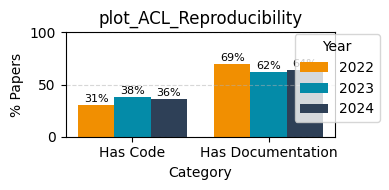

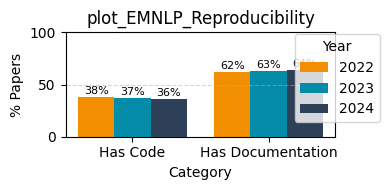

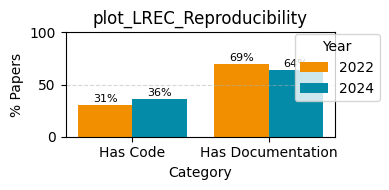

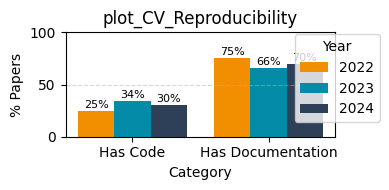

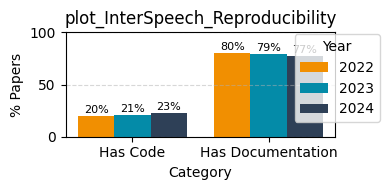

In [7]:
import json
import csv
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd

titles = {
    'rubric-1': "Data Annotations",
    'rubric-2': "Quality Assurance",
    'rubric-3': "Data Novelty",
    'rubric-4': "Task Utility",
    'rubric-5': "Language",
    'rubric-6': "Reproducibility"
}

def analyze_specific_rubric_trends(json_filepaths, csv_filepaths, conference_names, target_rubrics):
    """
    Analyzes trends for specific rubrics across multiple conferences,
    aggregating all categories except 'N/A' into an 'All Other Categories (OR)' group.

    Args:
        json_filepaths (list): A list of file paths to the JSON files, one for each conference.
        csv_filepaths (list): A list of file paths to the CSV files, one for each conference.
        conference_names (list): A list of names for each conference, corresponding to file paths.
        target_rubrics (list): A list of rubric IDs (e.g., ['rubric-1', 'rubric-2'])
                                for which to apply the specific aggregation logic.

    Returns:
        dict: A nested dictionary containing yearly counts for 'N/A' and
              'All Other Categories (OR)', grouped by conference name and then by target rubric ID.
              Structure: {conference_name: {rubric_id: {year: {'N/A': count, 'All Other Categories (OR)': count}}}}.
    """
    print(len(json_filepaths))
    if not (len(json_filepaths) == len(csv_filepaths) == len(conference_names)):
        print("Error: The lists of JSON file paths, CSV file paths, and conference names must be of the same length.")
        return {}

    all_conferences_rubric_data = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(int))))

    for conf_idx, conf_name in enumerate(conference_names):
        json_filepath = json_filepaths[conf_idx]
        csv_filepath = csv_filepaths[conf_idx]

        print(f"Processing data for conference: {conf_name}")

        # Load the CSV content using pandas
        try:
            csv_df = pd.read_csv(csv_filepath)
            id_to_year = csv_df.set_index('id')['year'].astype(str).to_dict()
        except FileNotFoundError:
            print(f"Error: CSV file not found at {csv_filepath} for {conf_name}. Skipping this conference.")
            continue
        except KeyError:
            print(f"Error: 'id' or 'year' column not found in CSV file {csv_filepath} for {conf_name}. Skipping this conference.")
            continue
        except Exception as e:
            print(f"Error loading or processing CSV file {csv_filepath} for {conf_name}: {e}. Skipping this conference.")
            continue

        # Load the JSON content using json.load
        try:
            with open(json_filepath, 'r') as f:
                json_data = json.load(f)
        except FileNotFoundError:
            print(f"Error: JSON file not found at {json_filepath} for {conf_name}. Skipping this conference.")
            continue
        except json.JSONDecodeError:
            print(f"Error: Could not decode JSON from {json_filepath} for {conf_name}. Check file format. Skipping this conference.")
            continue
        except Exception as e:
            print(f"Error loading JSON file {json_filepath} for {conf_name}: {e}. Skipping this conference.")
            continue

        # Process data for the current conference
        for entry in json_data:
            full_json_id = entry.get('id')
            base_json_id = "-".join(full_json_id.split("-")[:-2])
            rubric_id = "-".join(full_json_id.split("-")[-2:])
            actual_conf_name = conf_name
            if actual_conf_name == "NLP":
                actual_conf_name = full_json_id.split("-")[0].upper()

            # Only process if the rubric_id is one of the target rubrics
            if rubric_id == "rubric-1" or rubric_id == "rubric-6":
                year = id_to_year.get(base_json_id)
                if year:
                    try:
                        year = int(year)
                    except ValueError:
                        continue
                    
                    response_data = entry.get('response', {})
                    if not response_data:
                        continue
                    
                    # if rubric_id == "rubric-1":
                    #     section_content = response_data["data_annotations"]
                    #     if len(section_content) == 0:
                    #         all_conferences_rubric_data[conf_name][rubric_id][year]["N/A"] += 1
                    #     else:
                    #         for content in section_content:
                    #             found_guidelines = False
                    #             if "Automatic Process" != content["Subject Annotators"]:
                    #                 for key in content:
                    #                     if key != "Subject Annotators" and content[key]["is_applicable"]:
                    #                         found_guidelines = True 
                    #                         all_conferences_rubric_data[conf_name][rubric_id][year][key] += 1
                                        
                    #                 if not found_guidelines:
                    #                     all_conferences_rubric_data[conf_name][rubric_id][year]["N/A"] += 1


                    if rubric_id == "rubric-1":
                        section_content = response_data["data_annotations"]
                        if len(section_content) == 0:
                            all_conferences_rubric_data[actual_conf_name][rubric_id][year]["N/A"] += 1
                        else:
                            for content in section_content:
                                found_guidelines = False
                                if "Automatic Process" != content["Subject Annotators"]:
                                    for key in content:
                                        if key != "Subject Annotators" and content[key]["is_applicable"]:
                                            found_guidelines = True 
                                            all_conferences_rubric_data[actual_conf_name][rubric_id][year][key] += 1
                                        
                                    if not found_guidelines:
                                        all_conferences_rubric_data[actual_conf_name][rubric_id][year]["No Guidelines"] += 1
                                        
                    elif rubric_id == "rubric-6":
                        section_content = response_data["reproducibility"]
                        if section_content["code"]["Has Code"]:
                            all_conferences_rubric_data[actual_conf_name][rubric_id][year]["Has Code"] += 1
                        if section_content["documentation"]["Has Documentation"]:
                            all_conferences_rubric_data[actual_conf_name][rubric_id][year]["Has Documentation"] += 1
                                        
            elif rubric_id in target_rubrics:
                year = id_to_year.get(base_json_id)
                if year:
                    try:
                        year = int(year)
                    except ValueError:
                        continue

                    response_data = entry.get('response', {})
                    if not response_data:
                        continue

                    for section_name, section_content in response_data.items():
                        if isinstance(section_content, dict):
                            for category_name, category_details in section_content.items():
                                if isinstance(category_details, dict) and 'is_applicable' in category_details:
                                    if category_details.get('is_applicable') is True:
                                        all_conferences_rubric_data[actual_conf_name][rubric_id][year][category_name] += 1
    
    return all_conferences_rubric_data

import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
import matplotlib.cm as cm

colors = ["#f18f01", "#048ba8", "#2e4057"]

def plot_per_conference_by_category(all_conferences_rubric_data, target_rubrics):
    if not all_conferences_rubric_data:
        print("No data available.")
        return

    all_conferences = list(all_conferences_rubric_data.keys())

    for rubric_id in target_rubrics:
        for conf_name in all_conferences:
            conf_data = all_conferences_rubric_data[conf_name].get(rubric_id)
            if not conf_data:
                print(conf_data)
                print(f"No data for rubric {rubric_id} in {conf_name}. Skipping.")
                continue

            # Gather all years and categories for this conference + rubric
            all_years = sorted(conf_data.keys())
            all_categories = set()
            for year_data in conf_data.values():
                all_categories.update(year_data.keys())
            all_categories = sorted(all_categories)

            # Assign a unique color to each year using a colormap
            year_colors = {
                year: colors[i % 10]  # Use modulo in case more than 10 years
                for i, year in enumerate(all_years)
            }

            # Plot setup
            fig, ax = plt.subplots(figsize=(max(2.7, len(all_categories) * 2.05), 2))
            # ax.set_title(f'{conf_name} — Category Trends for Rubric {titles[rubric_id]}', fontsize=14)
            ax.set_ylabel('% Papers')
            ax.set_xlabel('Category')
            ax.grid(axis='y', linestyle='--', alpha=0.5)

            # Plot bar clusters
            num_years = len(all_years)
            group_width = 0.8
            bar_width = group_width / num_years

            x_positions = []
            x_labels = []

            for cat_idx, category in enumerate(all_categories):
                for year_idx, year in enumerate(all_years):
                    year_data = conf_data.get(year, {})
                    count = year_data.get(category, 0)
                    total = sum(year_data.values())
                    if total == 0:
                        continue

                    pct = count / total * 100
                    x_base = cat_idx
                    bar_offset = (year_idx - (num_years - 1) / 2) * bar_width
                    bar_pos = x_base + bar_offset + 0.5

                    ax.bar(
                        bar_pos, pct, bar_width,
                        color=year_colors[year],
                        # edgecolor='black',
                        label=str(year) if cat_idx == 0 else ""
                    )

                    if pct > 0:
                        ax.text(bar_pos, pct + 1, f"{pct:.0f}%", ha='center', va='bottom', fontsize=8)

                x_positions.append(cat_idx + 0.5)
                if "(" in category:
                    category = category.replace("(", "\n(")
                if "/" in category and category != "N/A":
                    category = category.replace("/", "\n/\n")
                if " and " in category:
                    category = category.replace(" and ", "\nand\n")
                if "Multiple " in category:
                    category = category.replace("Multiple", "Multiple\n")
                if "Single " in category:
                    category = category.replace("Single", "Single\n")
                if "New Data " in category:
                    category = category.replace("New Data", "New Data\n")
                if " Communication" in category:
                    category = category.replace(" Communication", "\nCommunication")
                if " Translation" in category:
                    category = category.replace(" Translation", "\nTranslation")
                if "Supervised Fine-tuning" in category:
                    category = category.replace("Supervised Fine-tuning", "SFT")
                # if "N/A" in category:
                #     category = category.replace("N/A", "None")
                x_labels.append(category)

            ax.set_xticks(x_positions)
            ax.set_xticklabels(x_labels)
            ax.set_ylim(0, 100)

            # Deduplicated legend
            handles, labels = ax.get_legend_handles_labels()
            unique = dict(zip(labels, handles))
            plt.tight_layout()
            plt.title(f"plot_{conf_name}_{titles[rubric_id]}")
            plt.savefig(f"plots/plot_{conf_name}_{titles[rubric_id]}_no_legend.png", dpi=300) 
            
            # ax.legend(unique.values(), unique.keys(), title="Year", loc='upper left')
            if rubric_id == "rubric-1":
                ax.legend(unique.values(), unique.keys(), title="Year", loc='upper right', bbox_to_anchor=(1.17, 1.05))
            elif rubric_id == "rubric-2" or rubric_id == "rubric-3":
                ax.legend(unique.values(), unique.keys(), title="Year", loc='upper right', bbox_to_anchor=(1.09, 1.05))
            elif rubric_id == "rubric-6":
                ax.legend(unique.values(), unique.keys(), title="Year", loc='upper right', bbox_to_anchor=(1.19, 1.05))
            elif rubric_id == "rubric-7":
                ax.legend(unique.values(), unique.keys(), title="Year", loc='upper right', bbox_to_anchor=(1.19, 1.05))
            else:
                ax.legend(unique.values(), unique.keys(), title="Year", loc='upper right', bbox_to_anchor=(1.15, 1.05))

            plt.tight_layout()
            plt.savefig(f"plots/plot_{conf_name}_{titles[rubric_id]}.png", dpi=300) 
            plt.show()

# Example Usage:
# json_file_path = 'neurips_qwen3_32b_full.json'
# csv_file_path = 'filtered_year_neurips_conference.csv'
# target_rubrics_to_plot = ['rubric-1', 'rubric-2'] # Specify the rubrics you want to plot with this aggregation

# 1. Analyze the data with specific aggregation
# aggregated_trends = analyze_specific_rubric_trends(json_file_path, csv_file_path, target_rubrics_to_plot)

# 2. Plot the trends for the specified rubrics
# plot_specific_rubric_trends(aggregated_trends)

target_rubrics_to_plot = ['rubric-1', 'rubric-2', 'rubric-3', 'rubric-4', 'rubric-5', 'rubric-6']
json_file_paths = ['../data/rubric_gen_results/gpt41mini_result_neurips.json',
                   '../data/rubric_gen_results/gpt41mini_result_iclr.json',
                   '../data/rubric_gen_results/gpt41mini_result_icml.json',
                   '../data/rubric_gen_results/gpt41mini_result_nlp.json',
                   '../data/rubric_gen_results/gpt41mini_result_cv.json',
                   '../data/rubric_gen_results/gpt41mini_result_interspeech.json']
csv_file_paths = ['../data/csv/sampled_filtered_year_neurips_papers.csv', 
                  '../data/csv/sampled_filtered_year_iclr_papers.csv',
                  '../data/csv/sampled_filtered_year_icml_papers.csv',
                  '../data/csv/sampled_filtered_year_nlp_papers.csv', 
                  '../data/csv/sampled_filtered_year_cv_papers.csv',
                  '../data/csv/sampled_filtered_year_interspeech_papers.csv']

conference_names = ['NeurIPS', 'ICLR', 'ICML', 'NLP', 'CV', 'InterSpeech']

aggregated_trends = analyze_specific_rubric_trends(json_file_paths, csv_file_paths, conference_names, target_rubrics_to_plot)

plot_per_conference_by_category(aggregated_trends, target_rubrics_to_plot)


6
Processing data for conference: NeurIPS
Processing data for conference: ICLR
Processing data for conference: ICML
Processing data for conference: NLP
Processing data for conference: CV
Processing data for conference: InterSpeech
defaultdict(<function analyze_specific_rubric_trends.<locals>.<lambda> at 0x13144fe20>, {'NeurIPS': defaultdict(<function analyze_specific_rubric_trends.<locals>.<lambda>.<locals>.<lambda> at 0x132e853f0>, {'rubric-0': defaultdict(<function analyze_specific_rubric_trends.<locals>.<lambda>.<locals>.<lambda>.<locals>.<lambda> at 0x132e87010>, {2022: defaultdict(<function analyze_specific_rubric_trends.<locals>.<lambda>.<locals>.<lambda>.<locals>.<lambda>.<locals>.<lambda> at 0x132e85630>, {'Poster': defaultdict(<class 'int'>, {'image': 51, 'text': 40, 'signal/sensor': 11, 'graph': 7, 'tabular': 24, 'video': 9, 'audio': 3, 'time series': 14, 'other': 4}), 'Highlighted': defaultdict(<class 'int'>, {'text': 13, 'image': 7, 'video': 4, 'signal/sensor': 2, 'tabular'

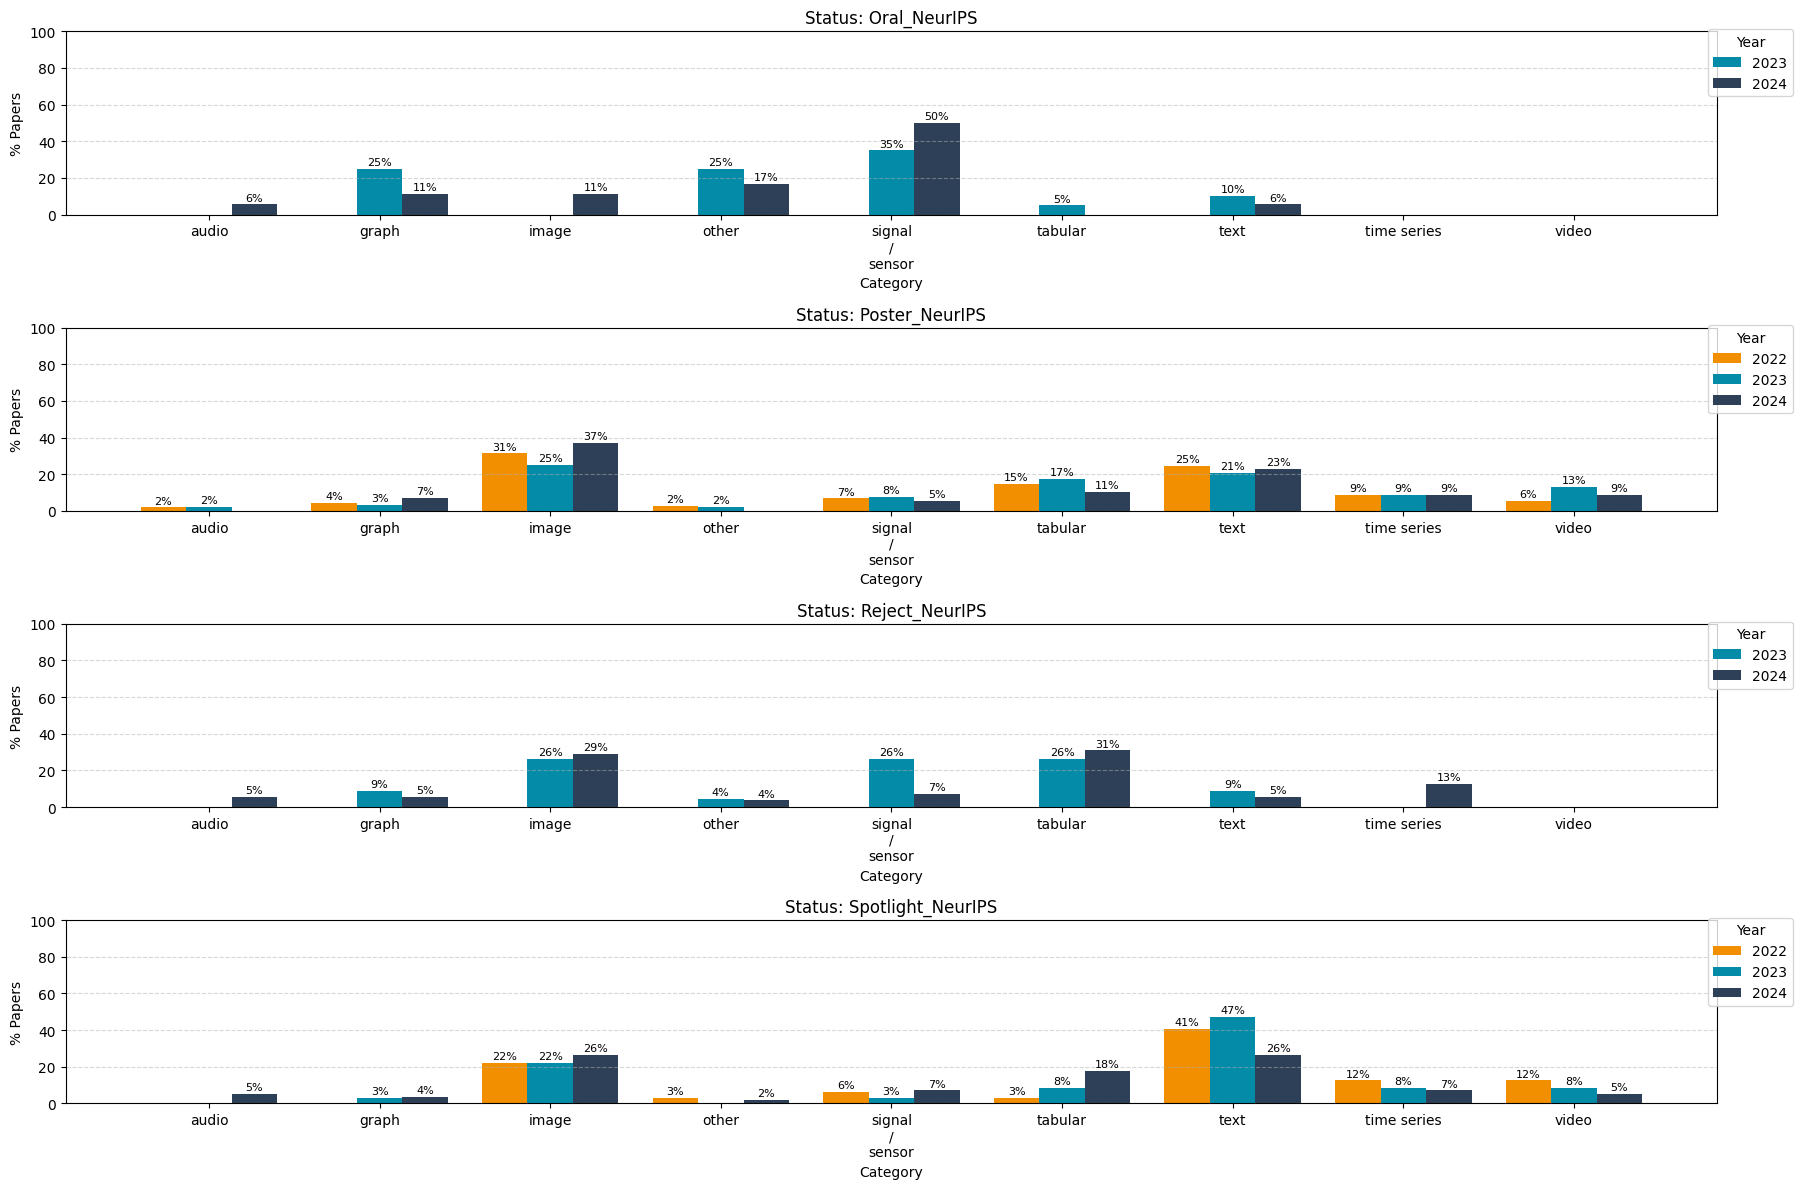

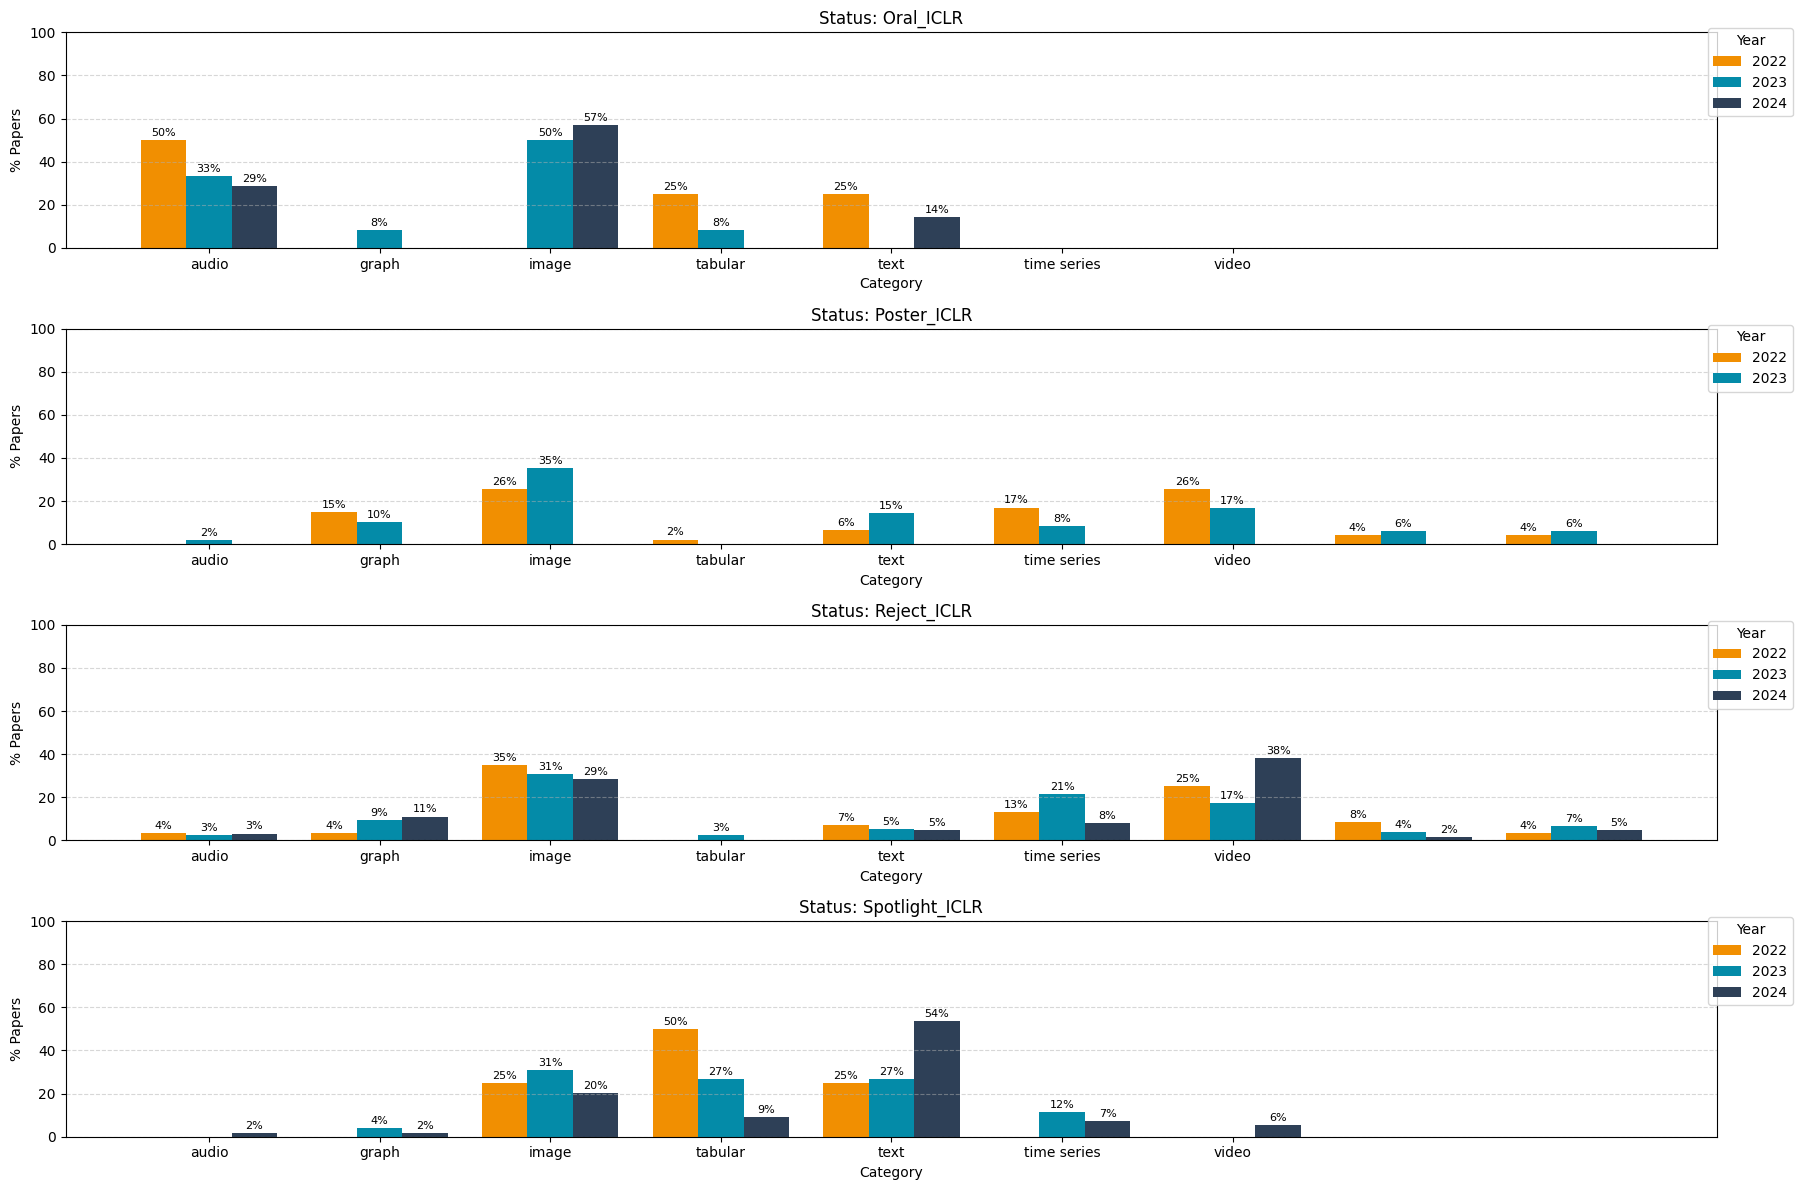

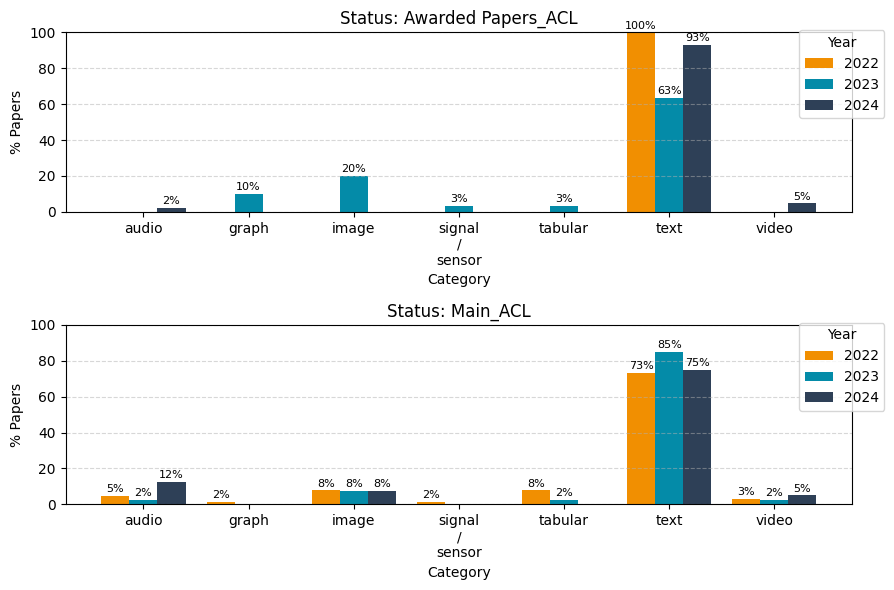

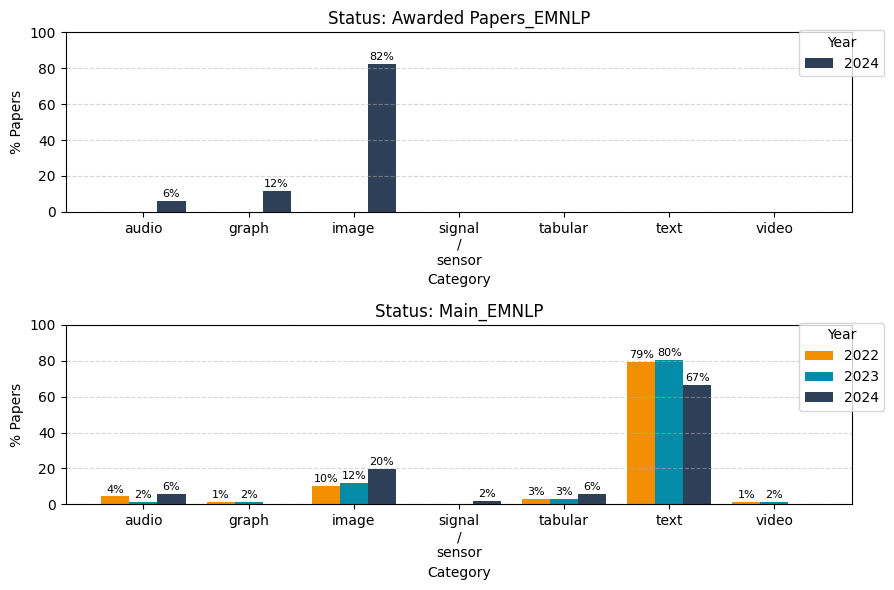

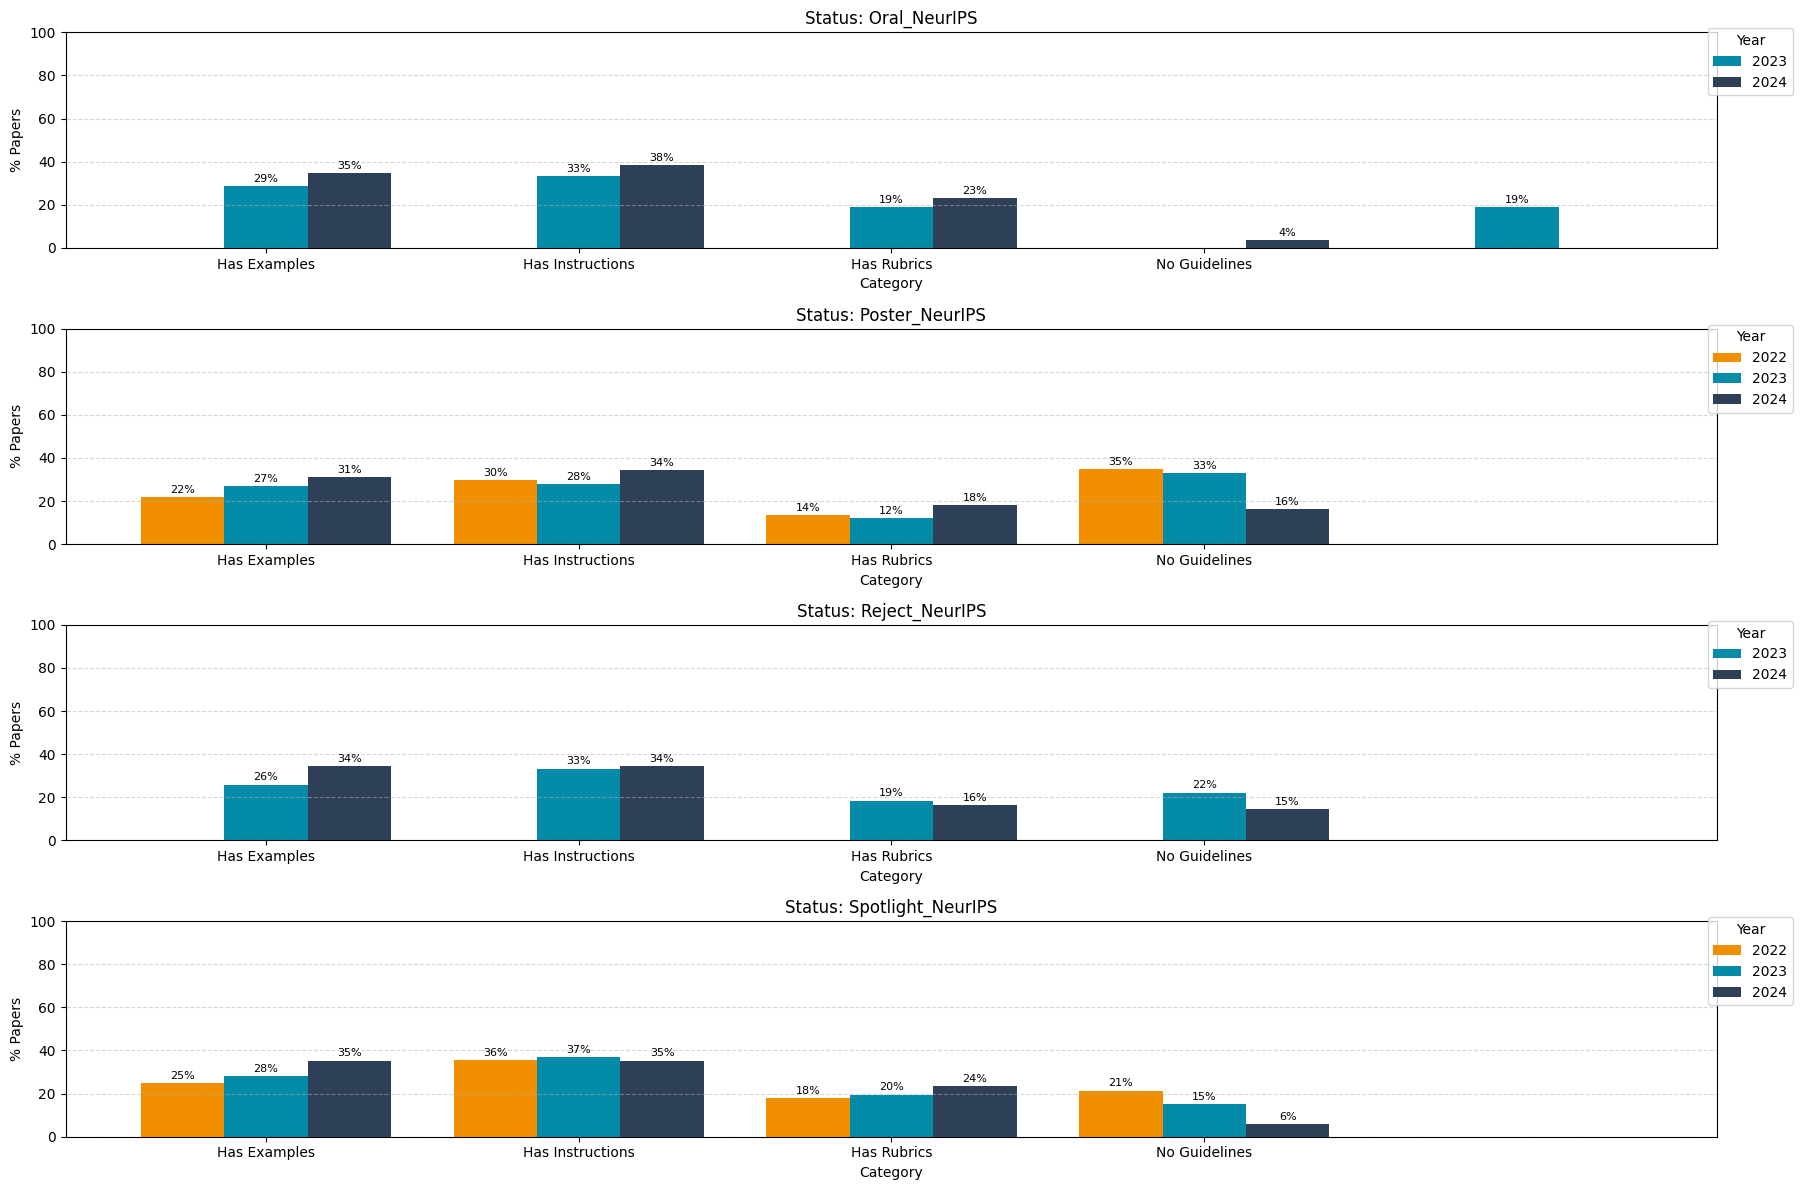

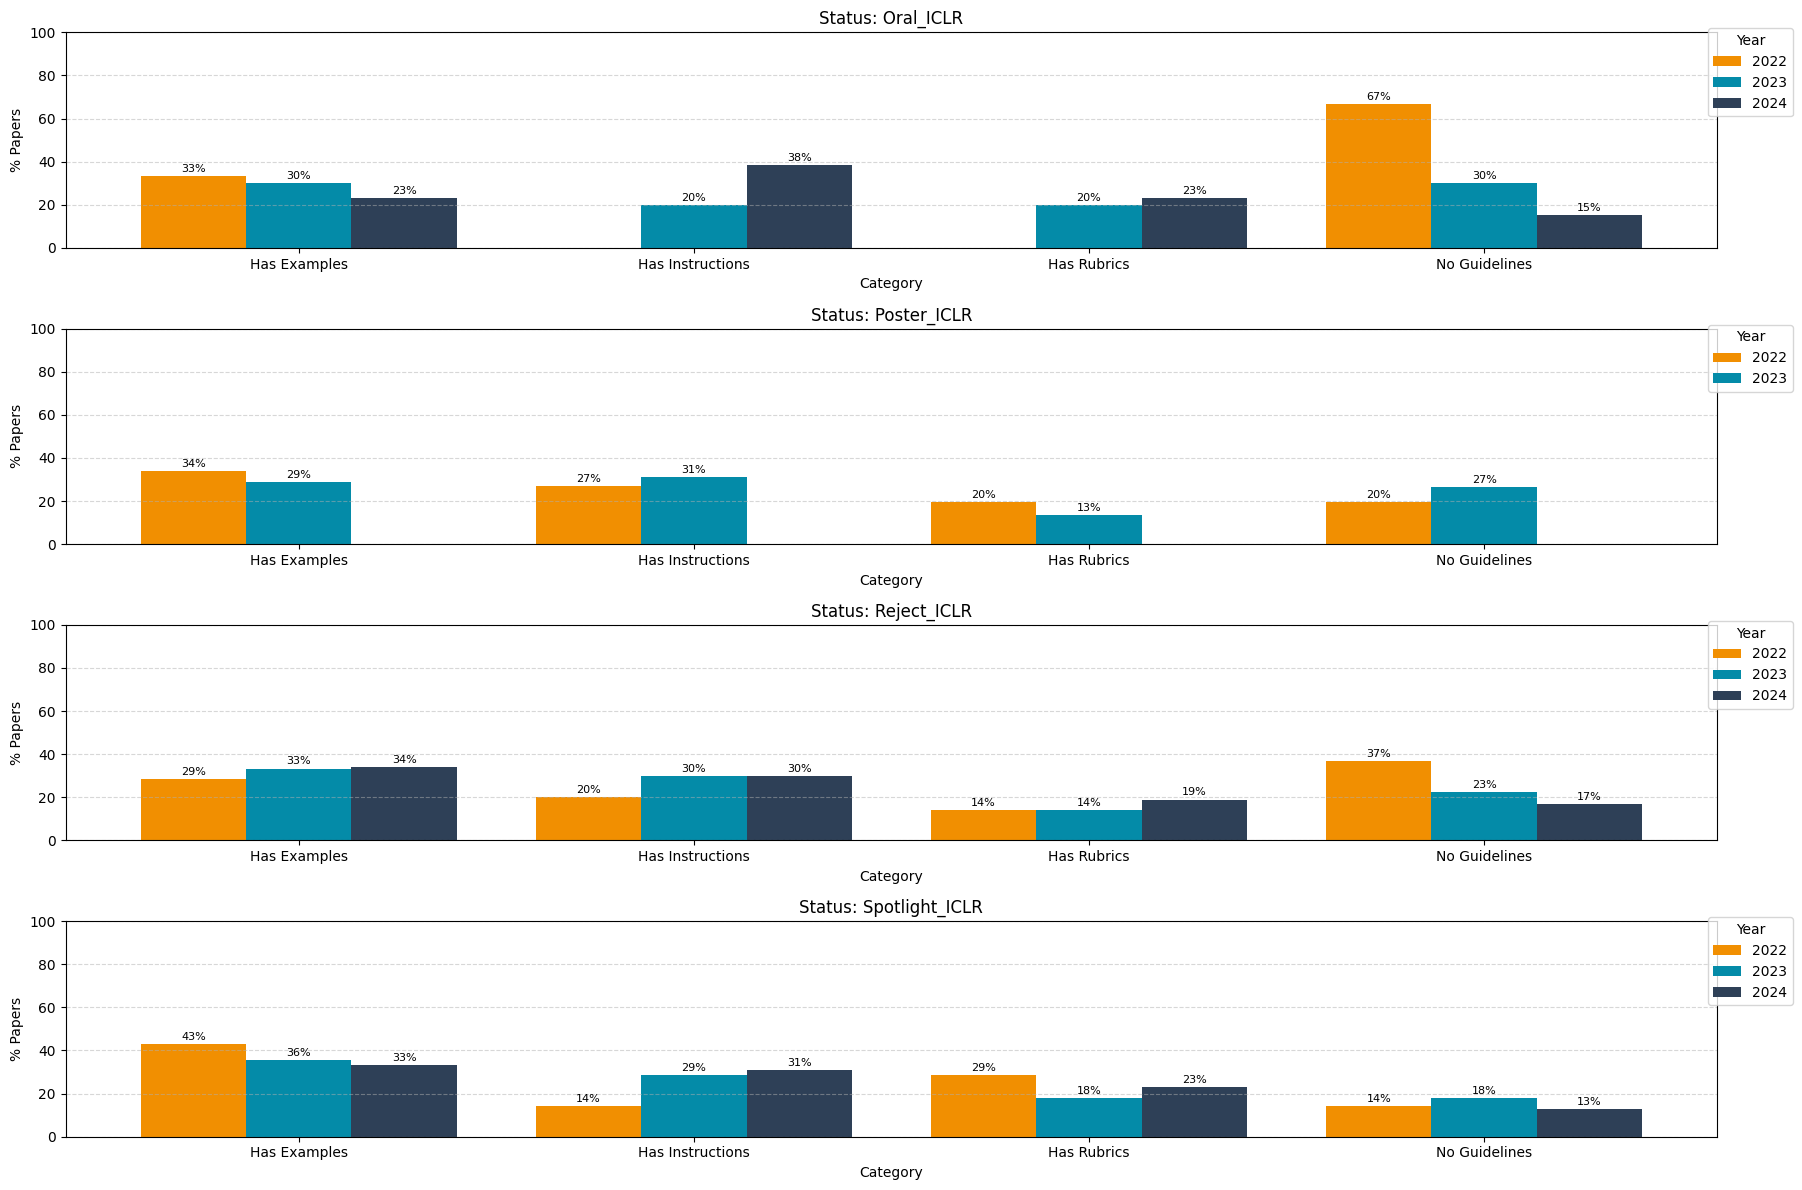

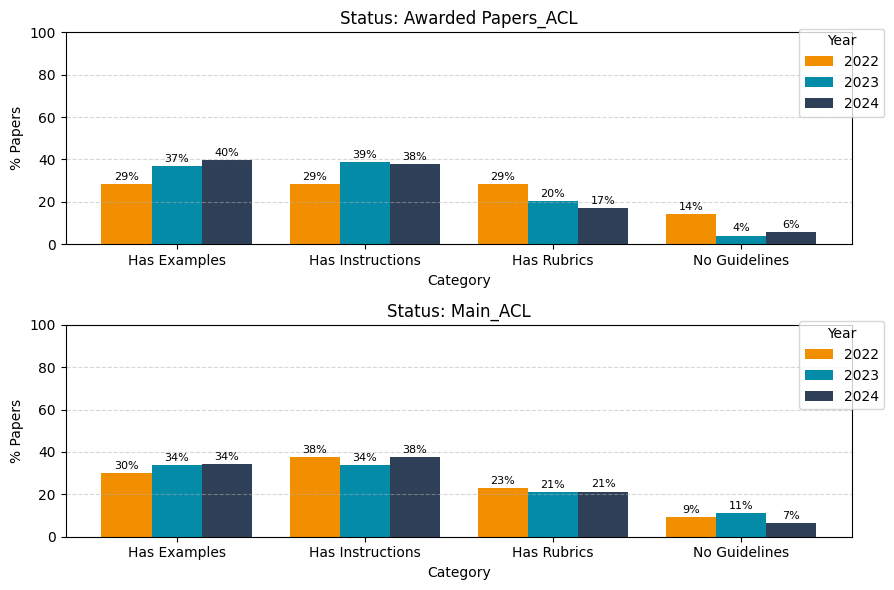

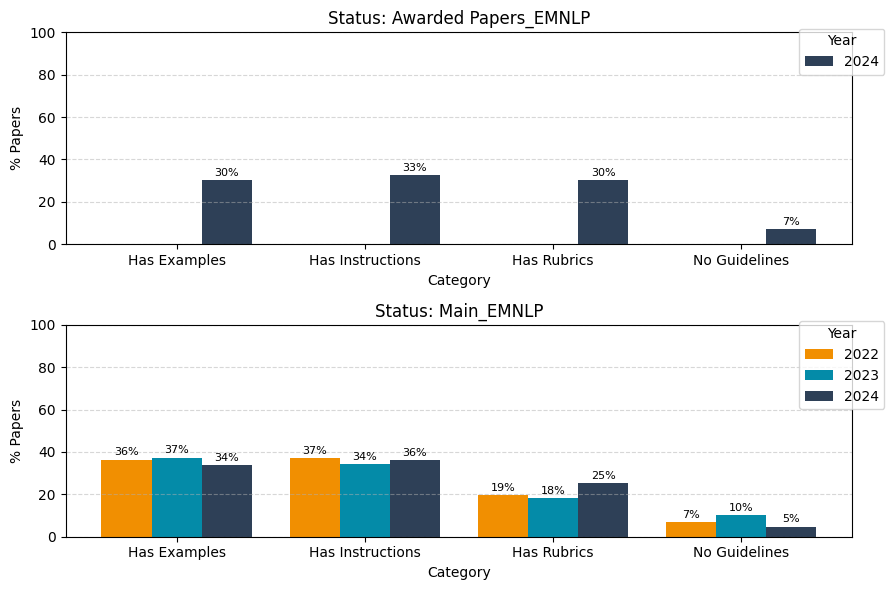

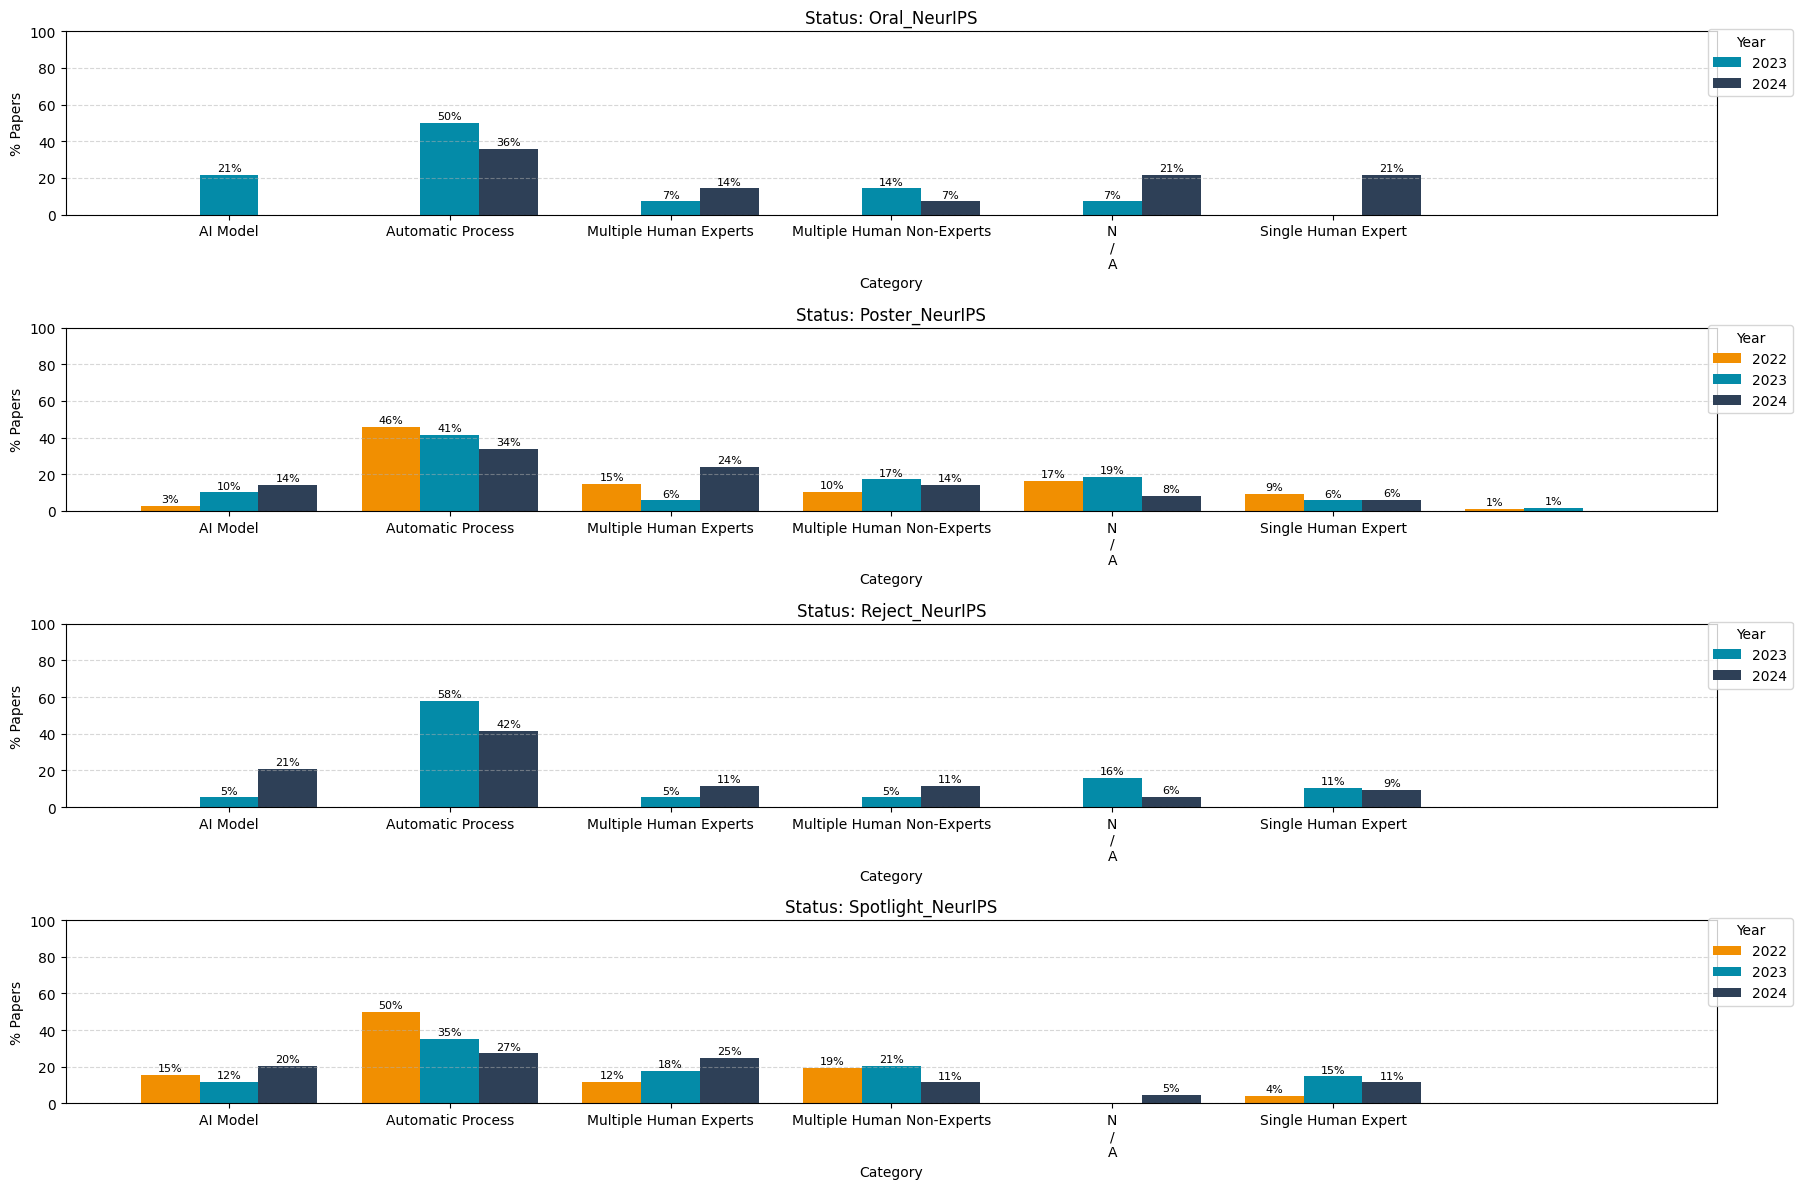

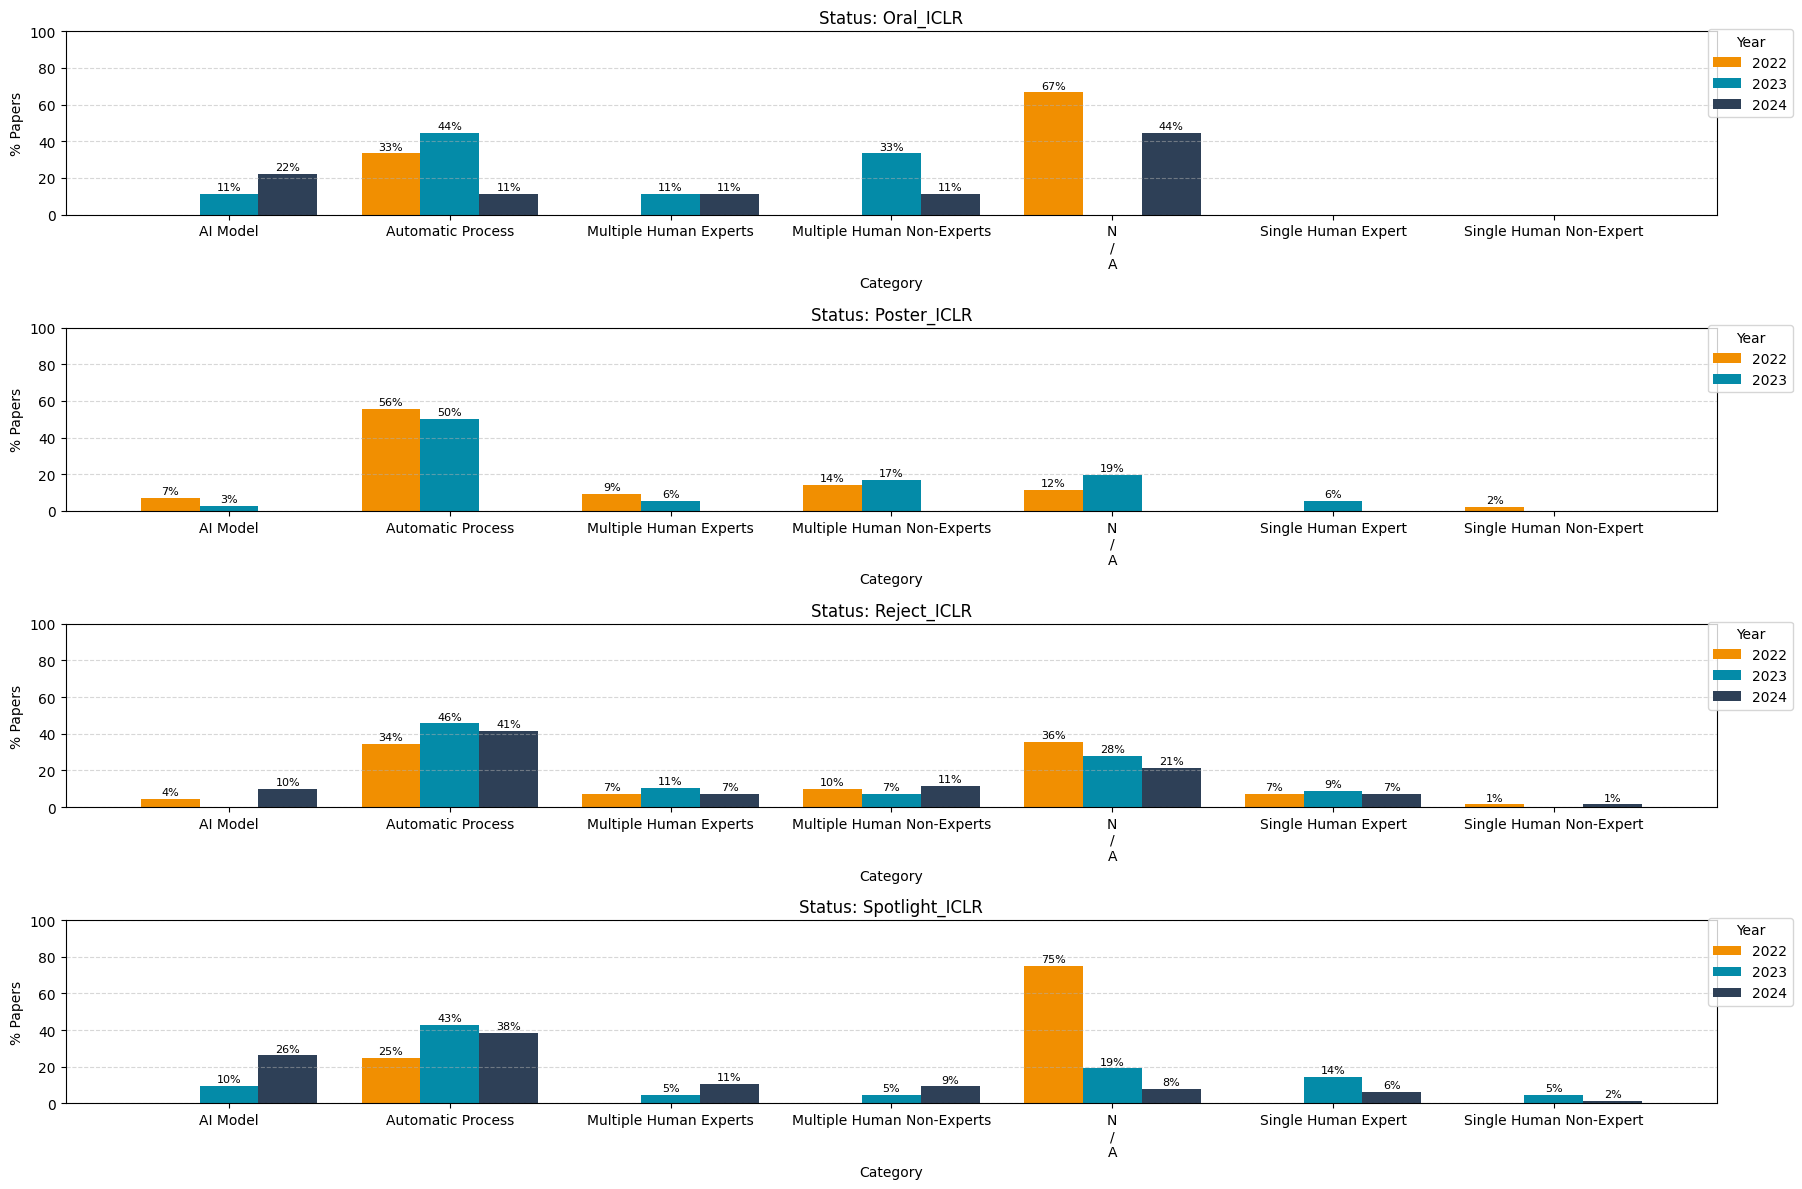

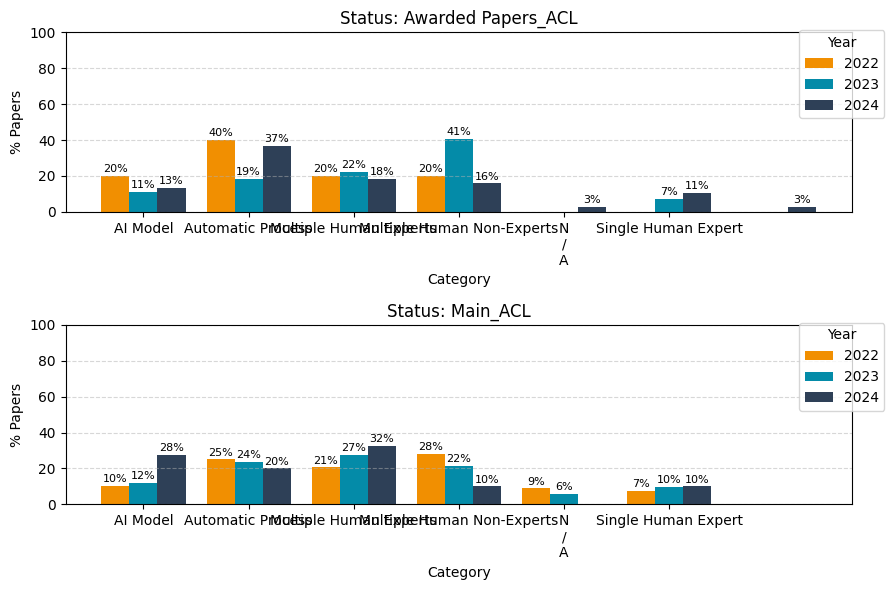

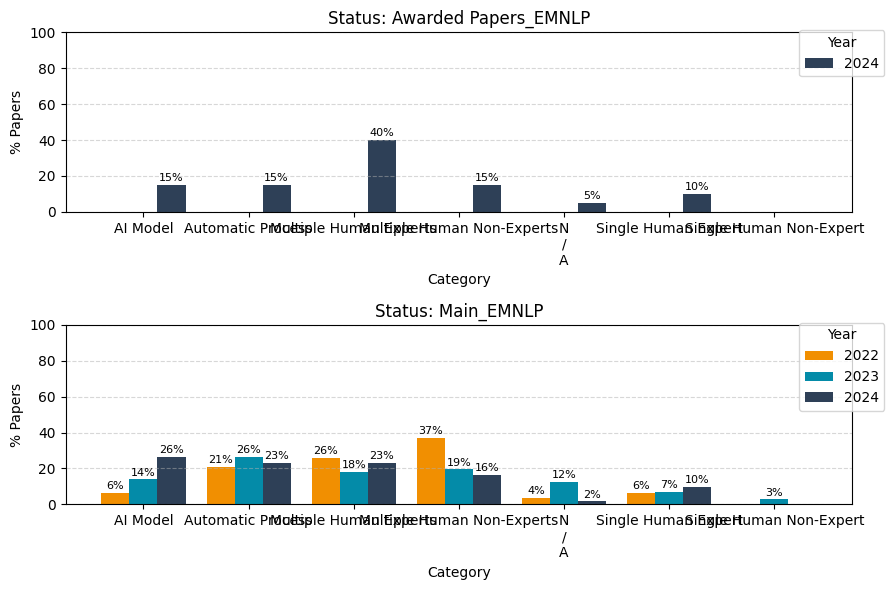

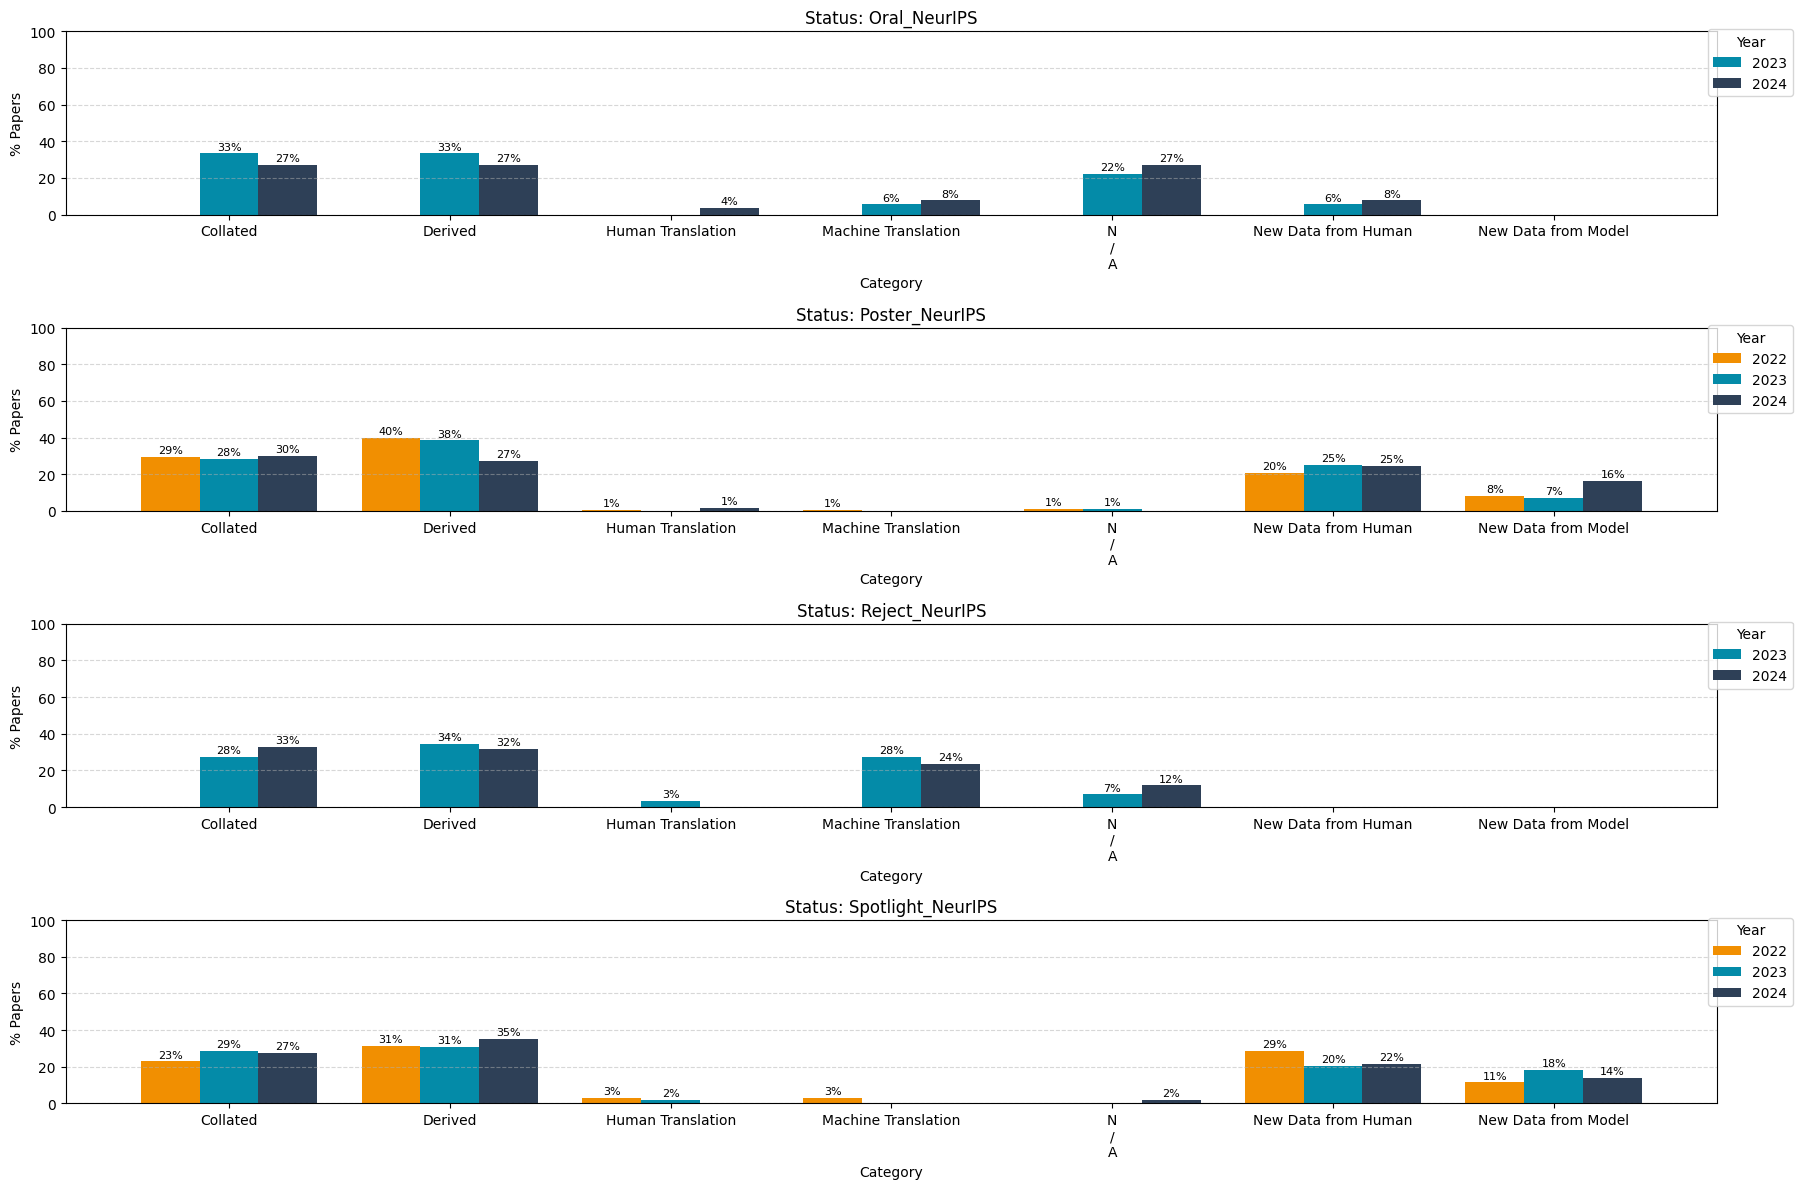

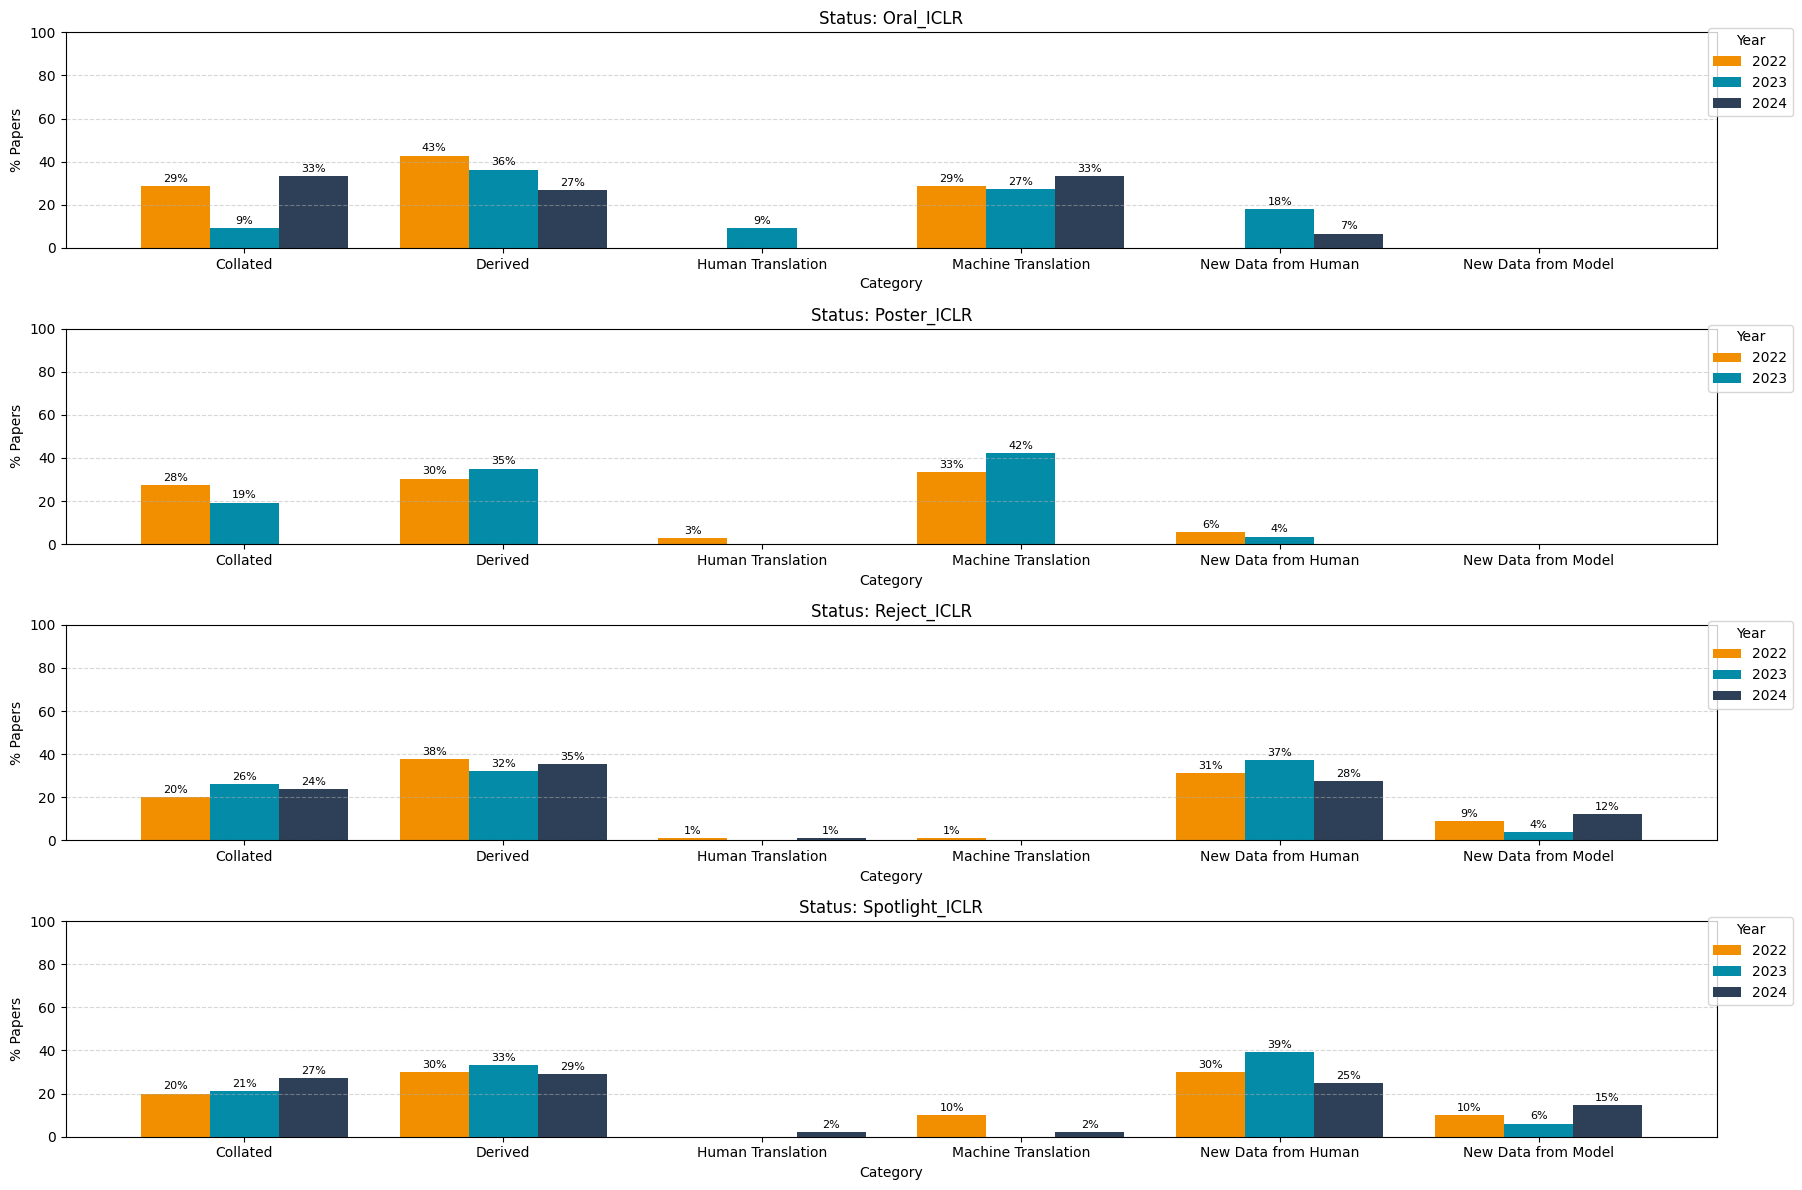

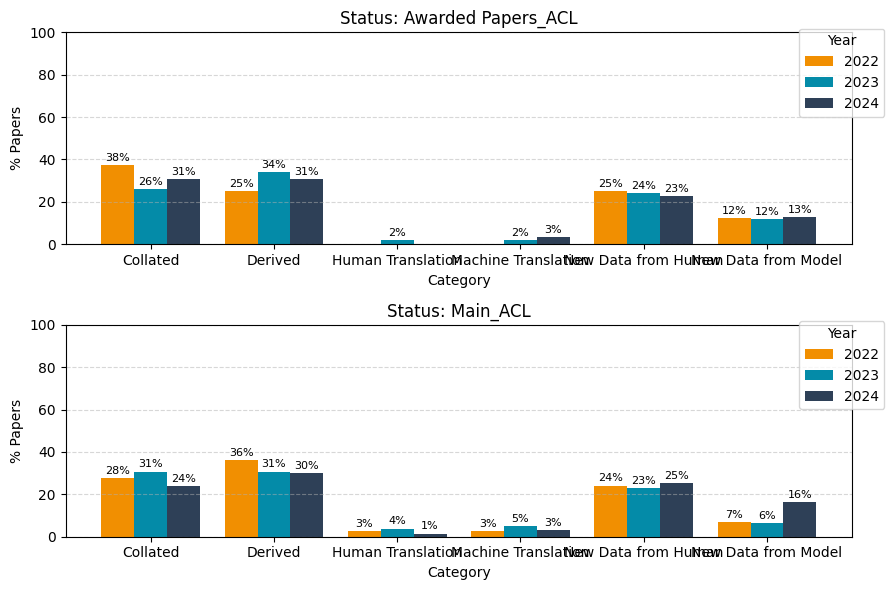

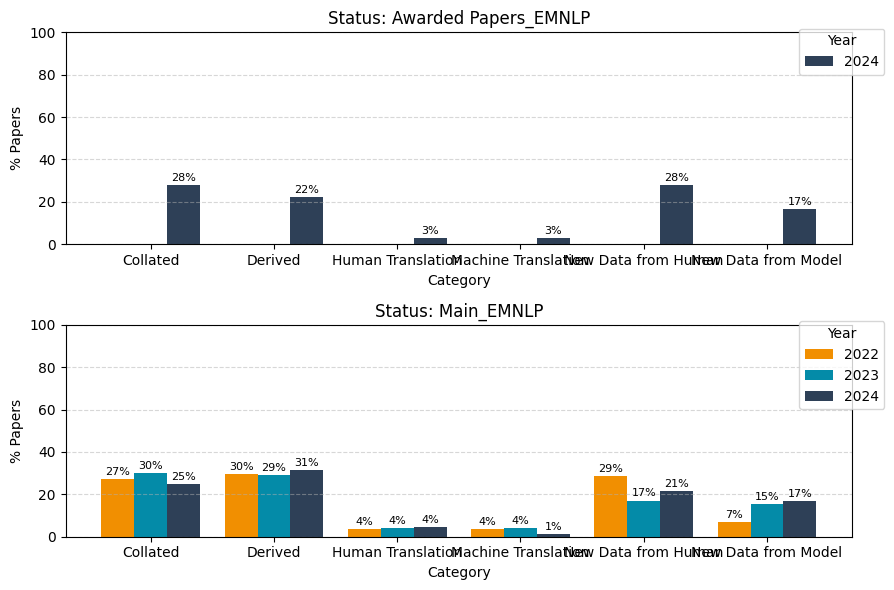

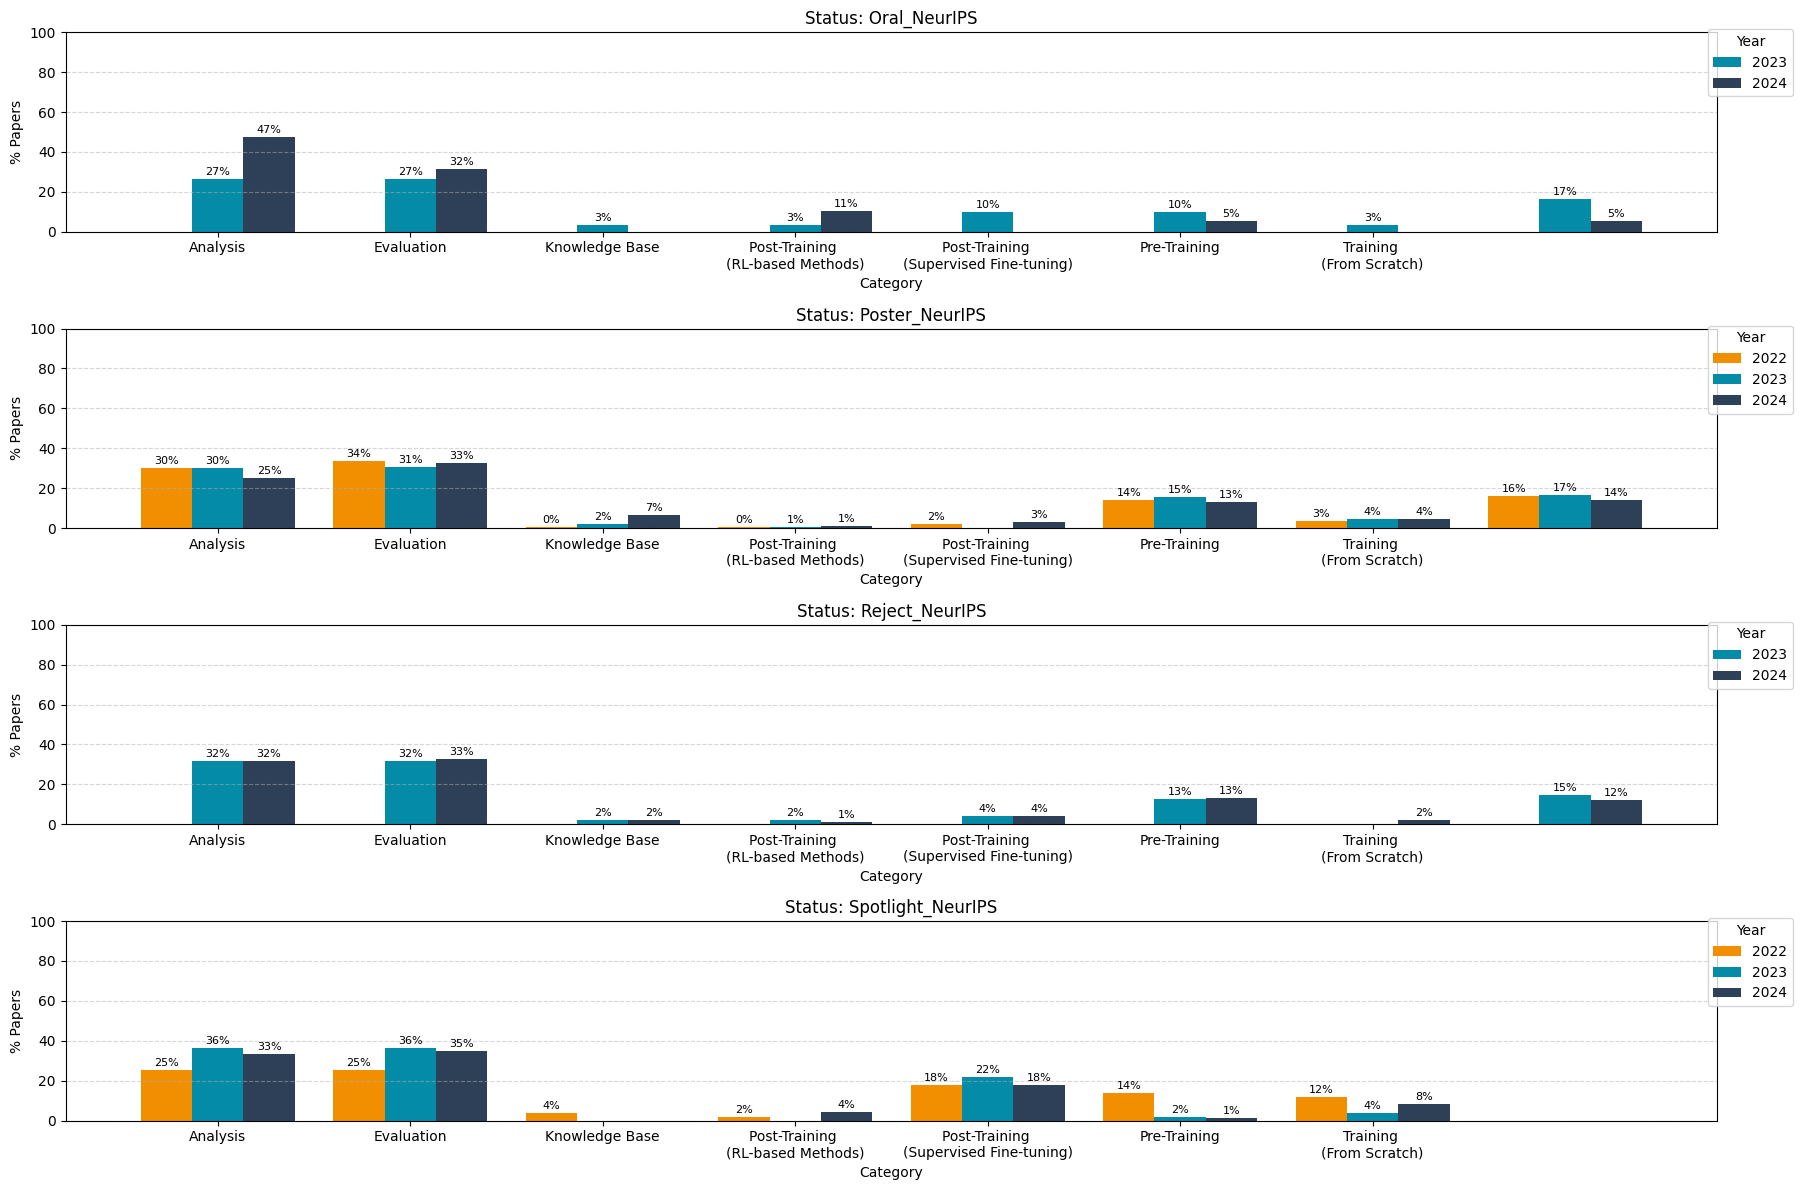

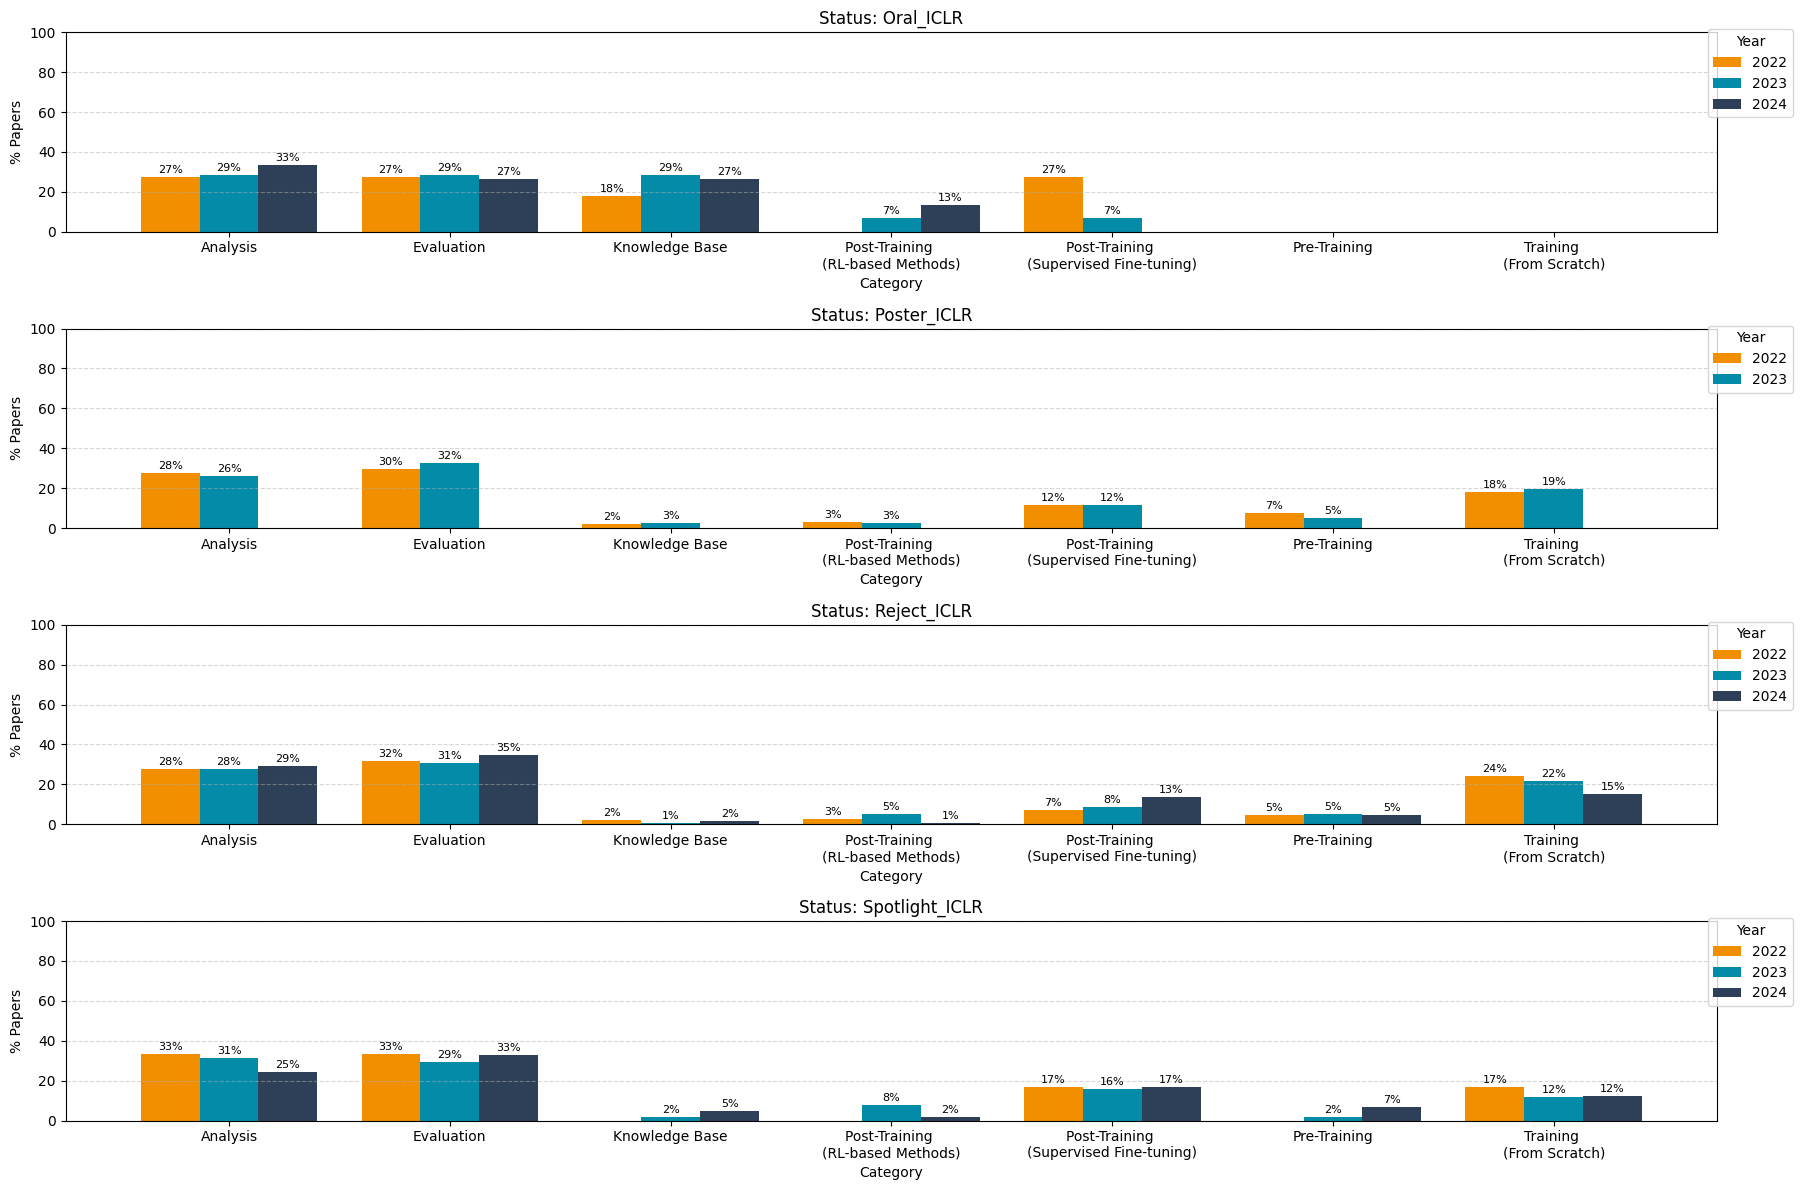

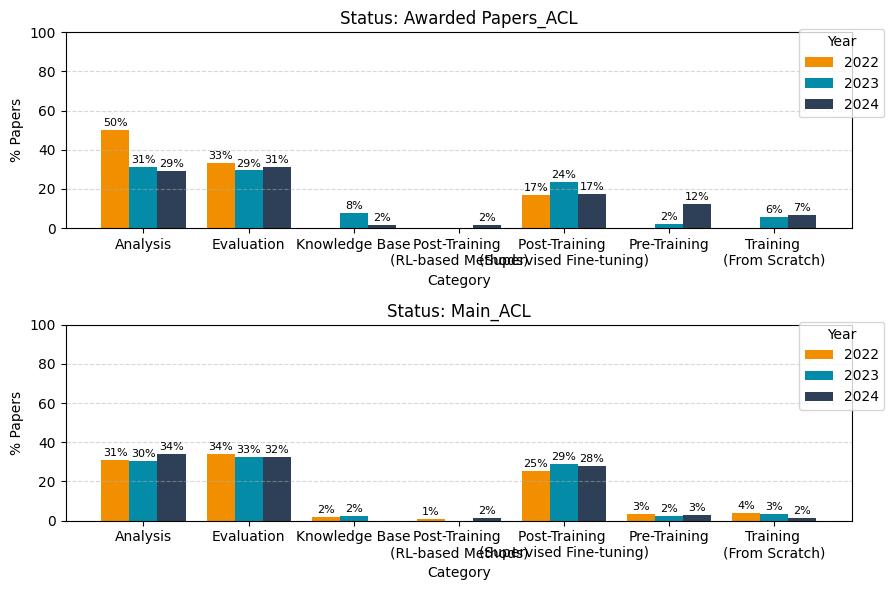

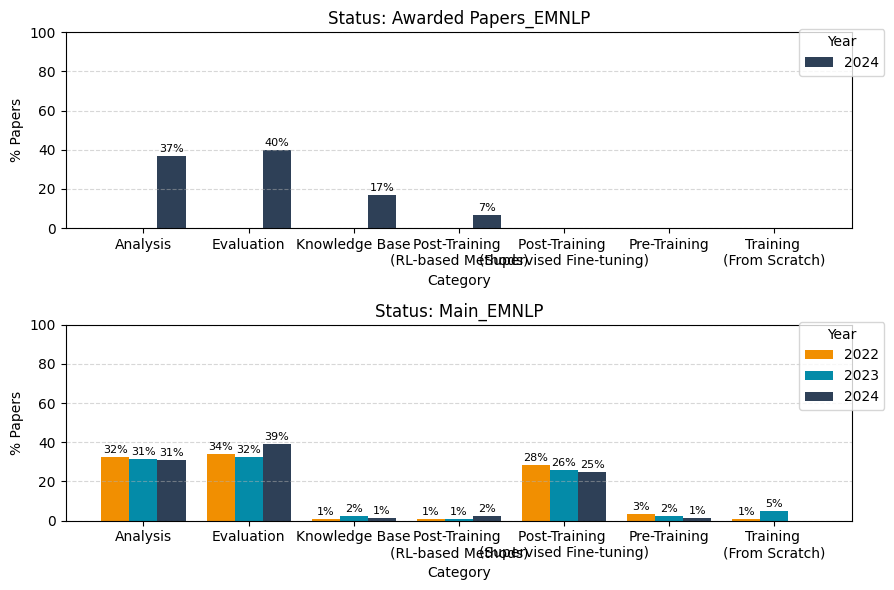

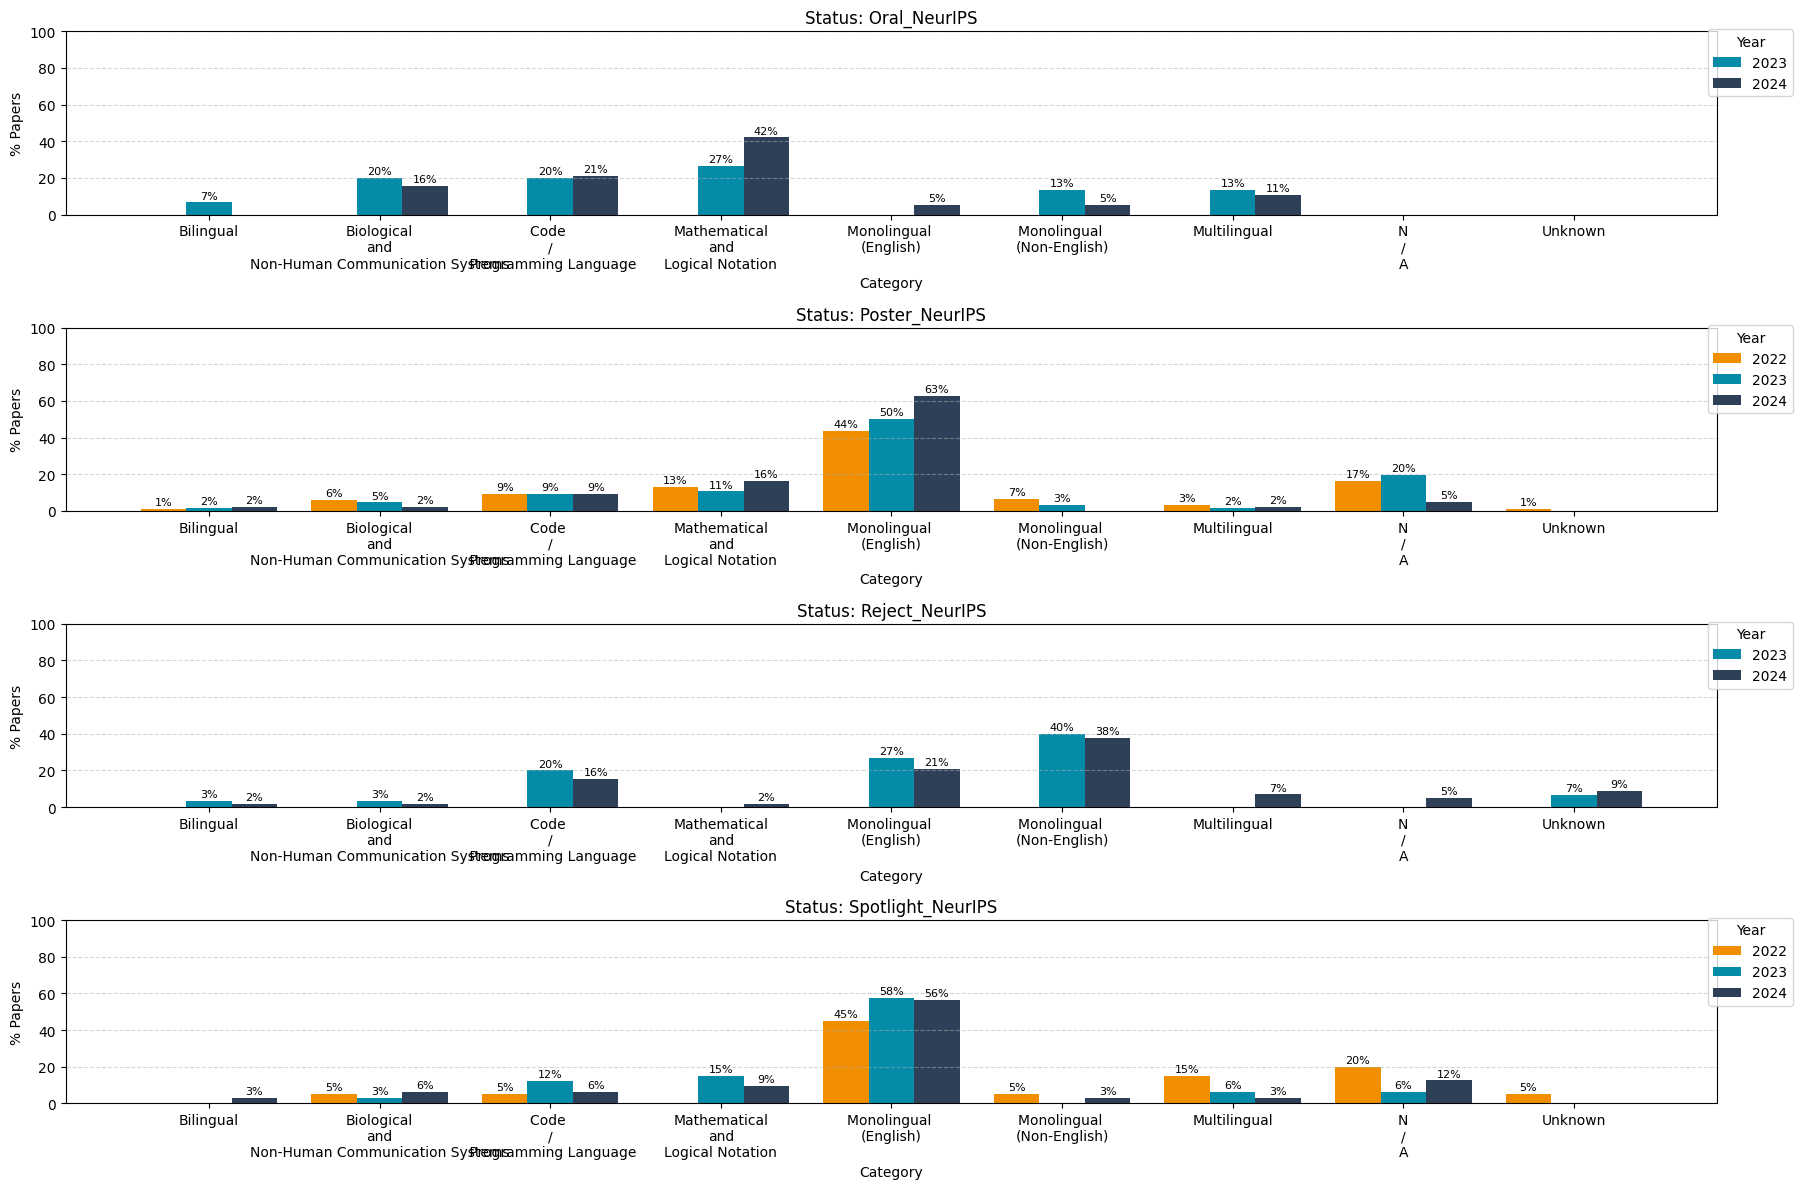

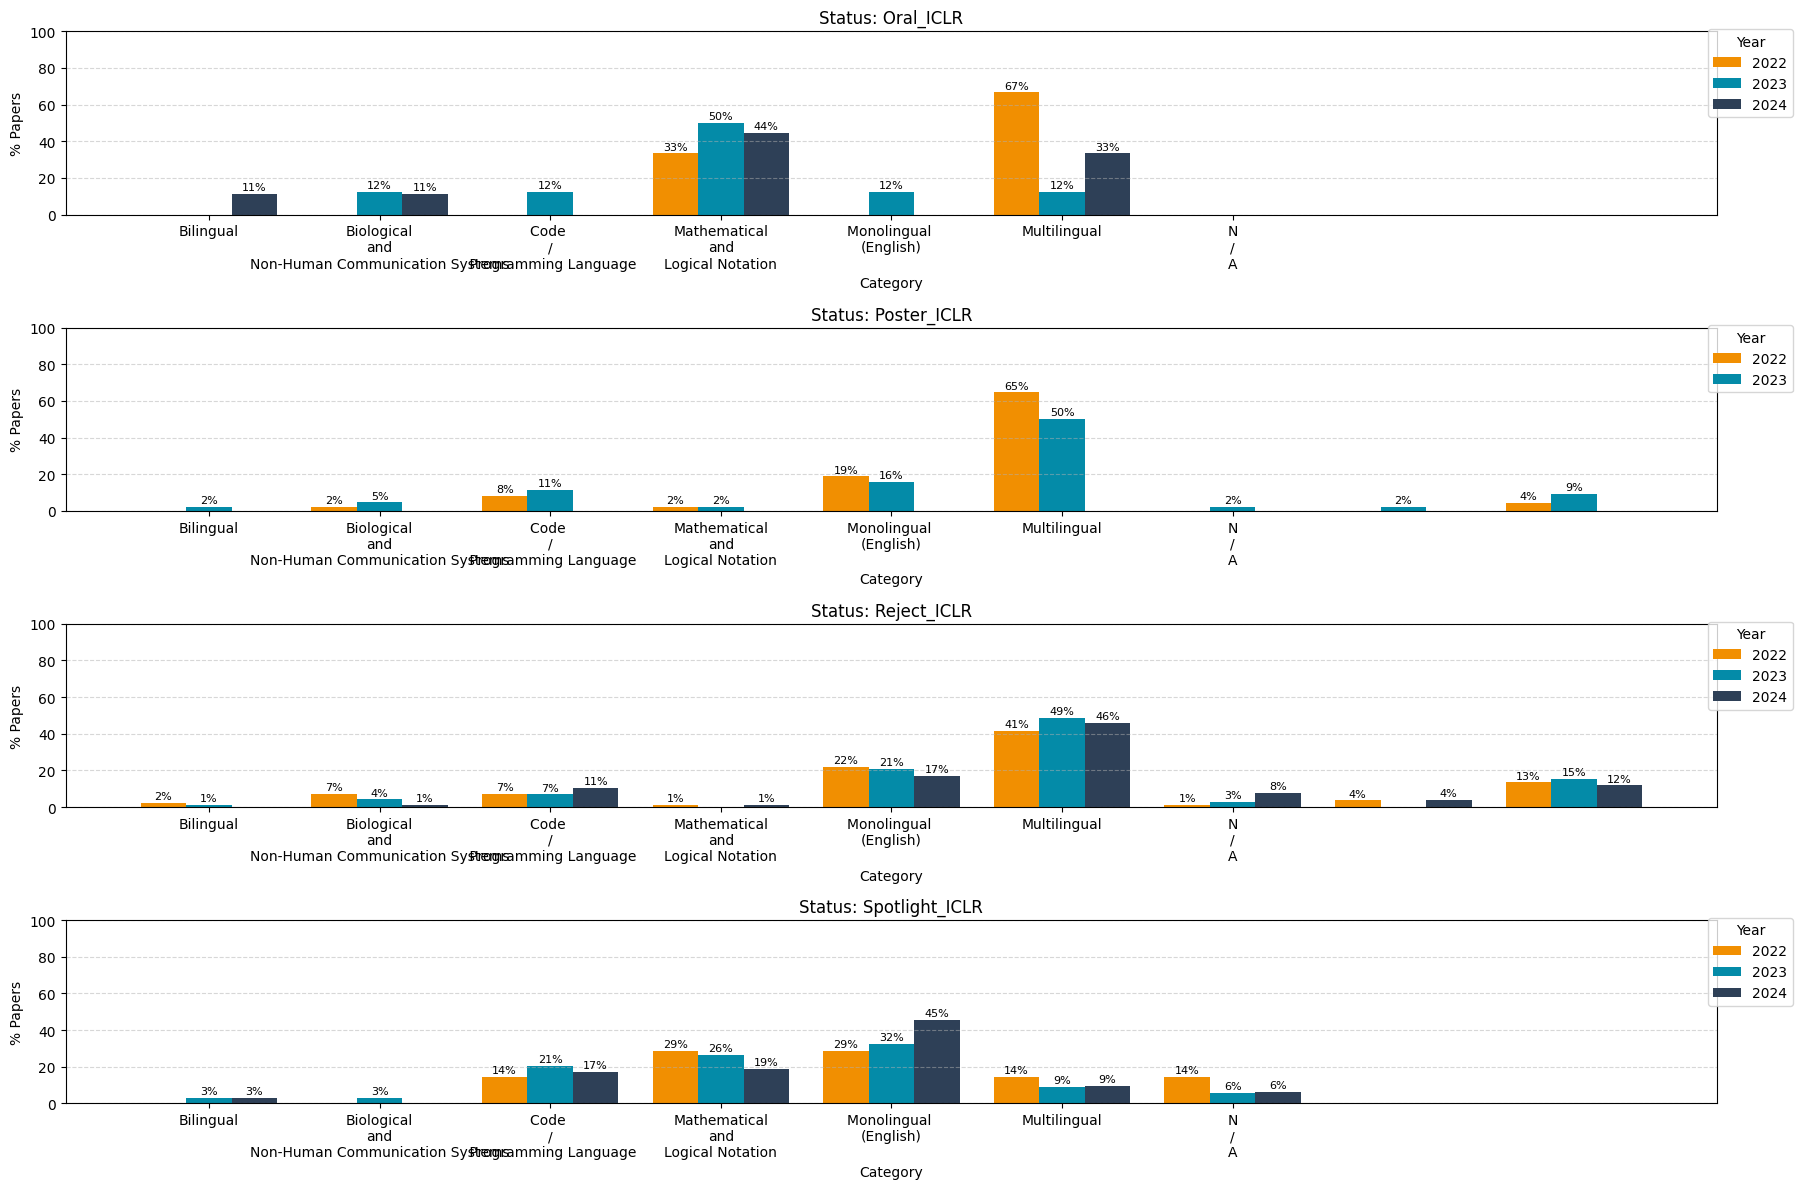

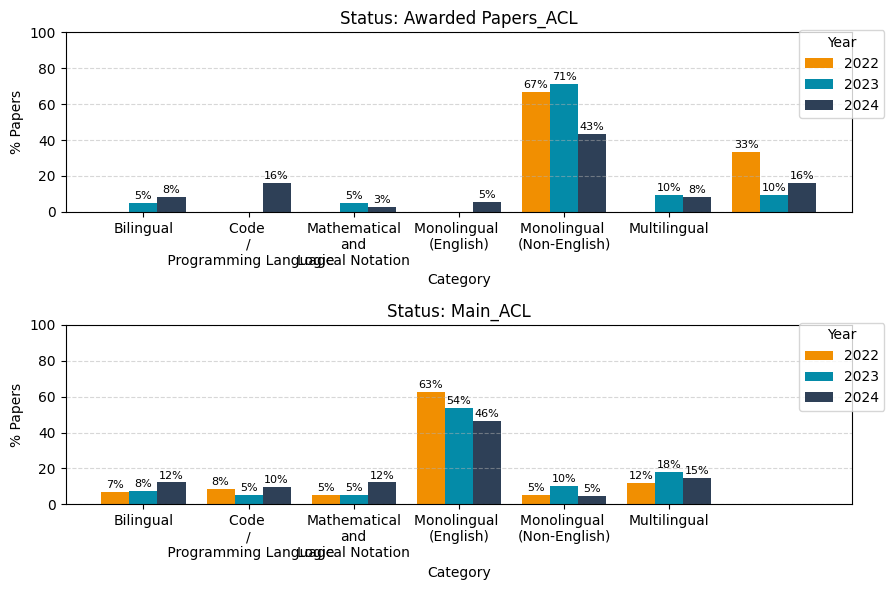

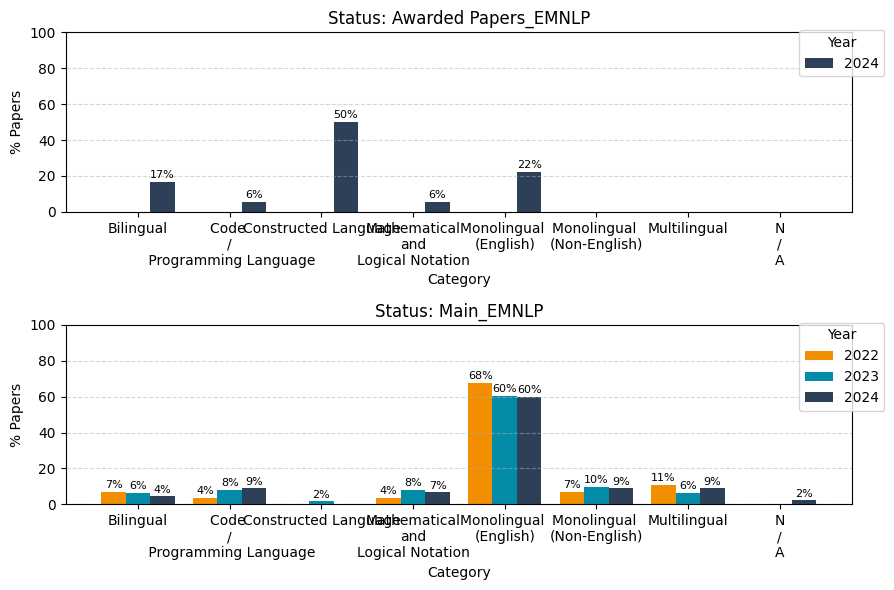

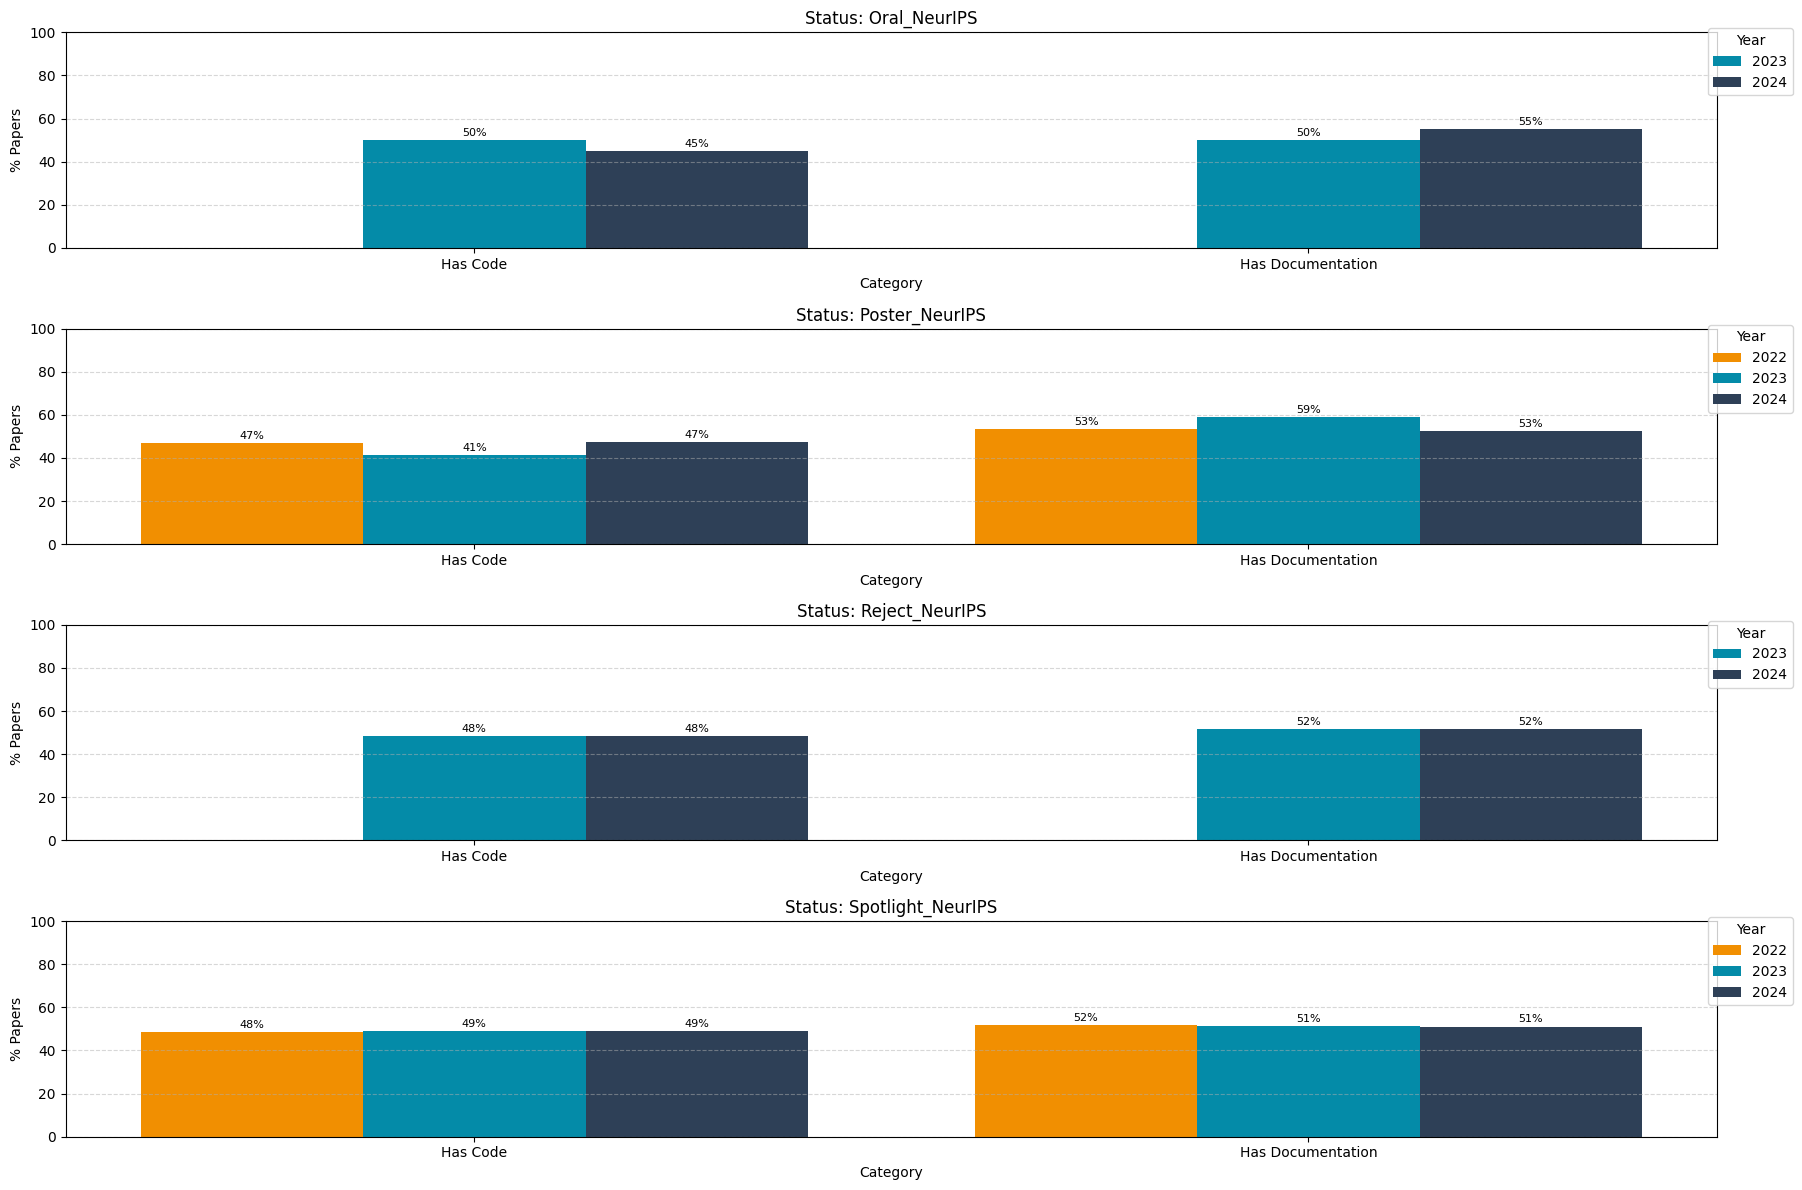

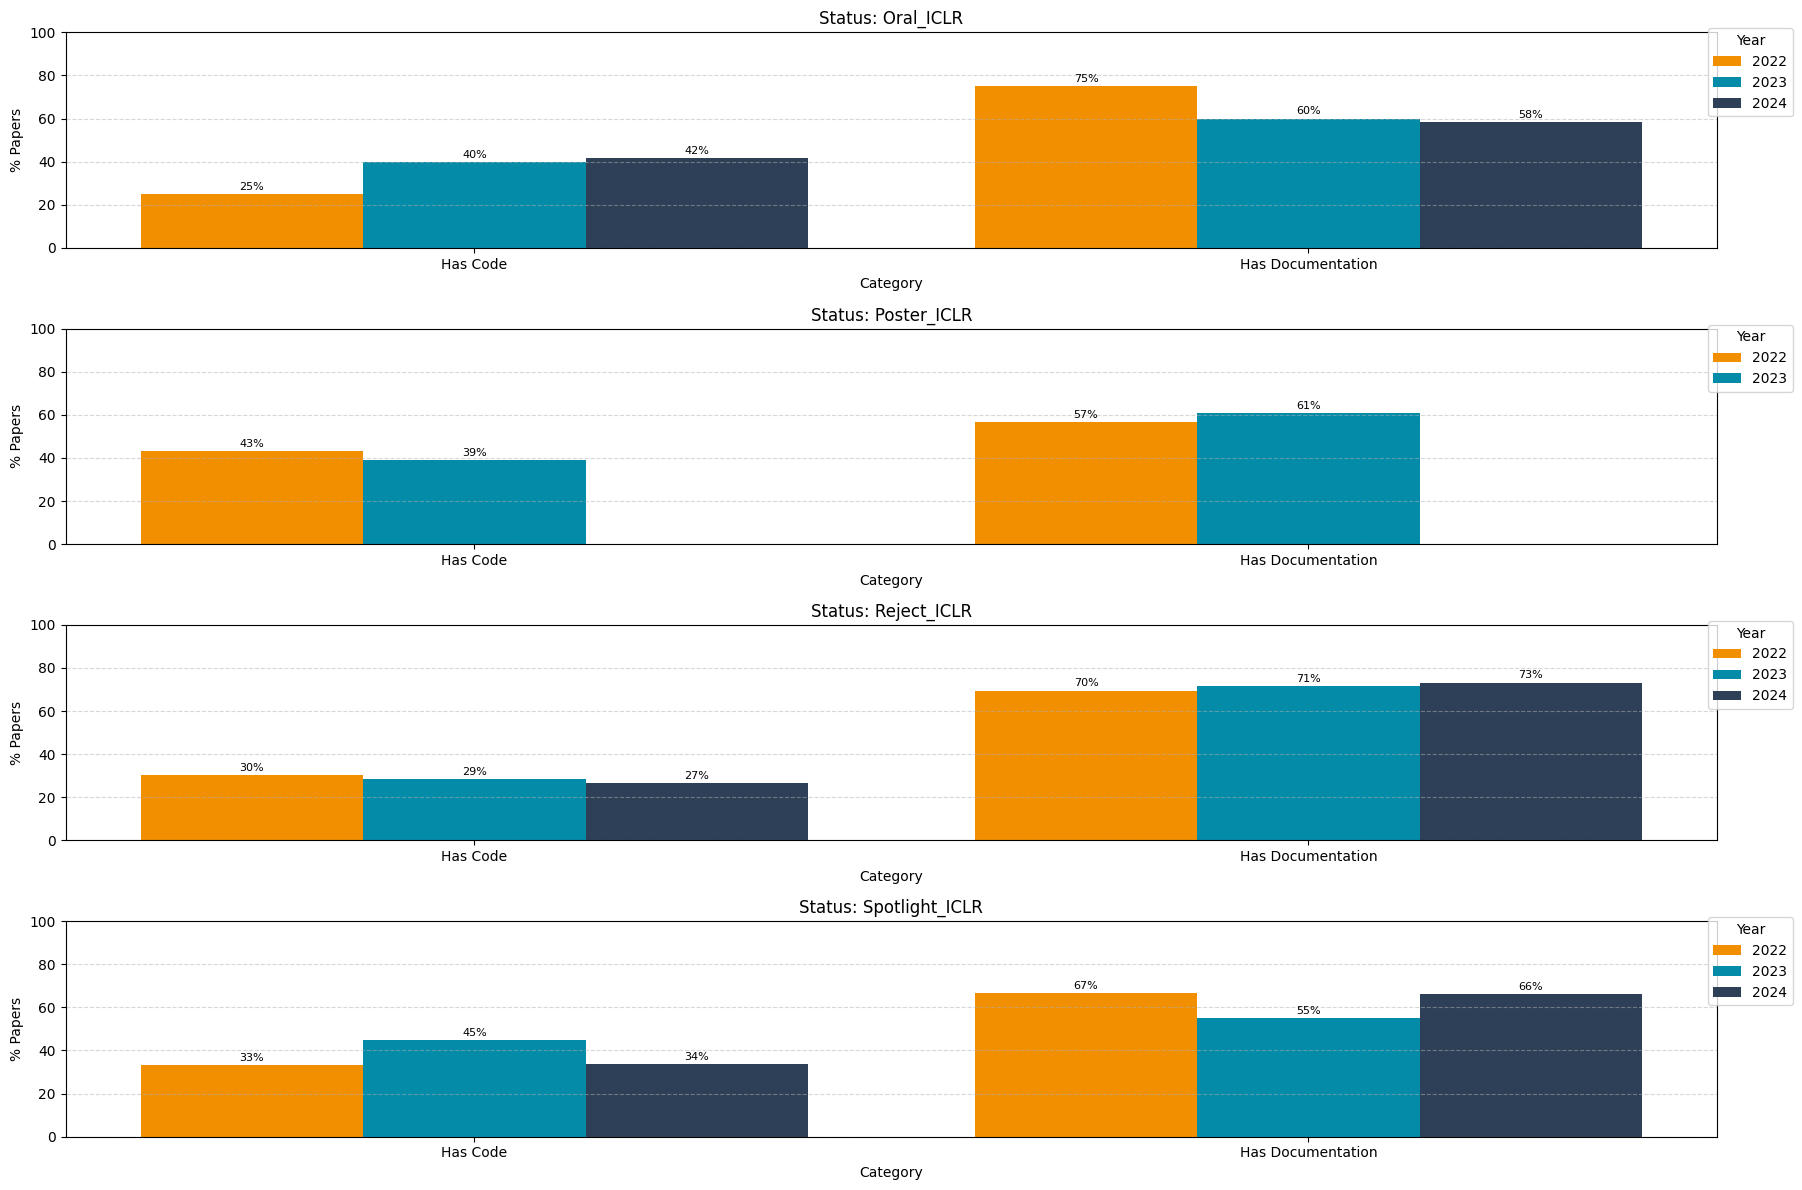

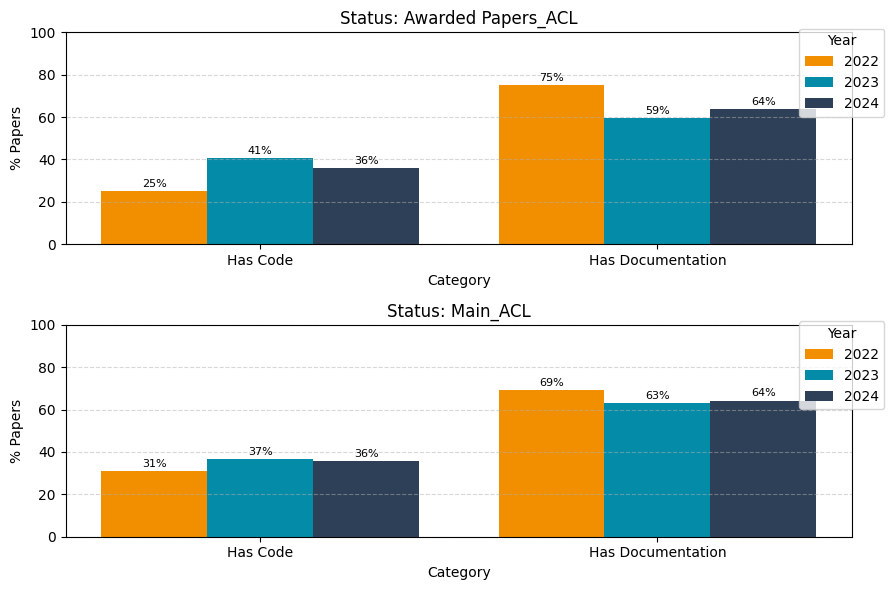

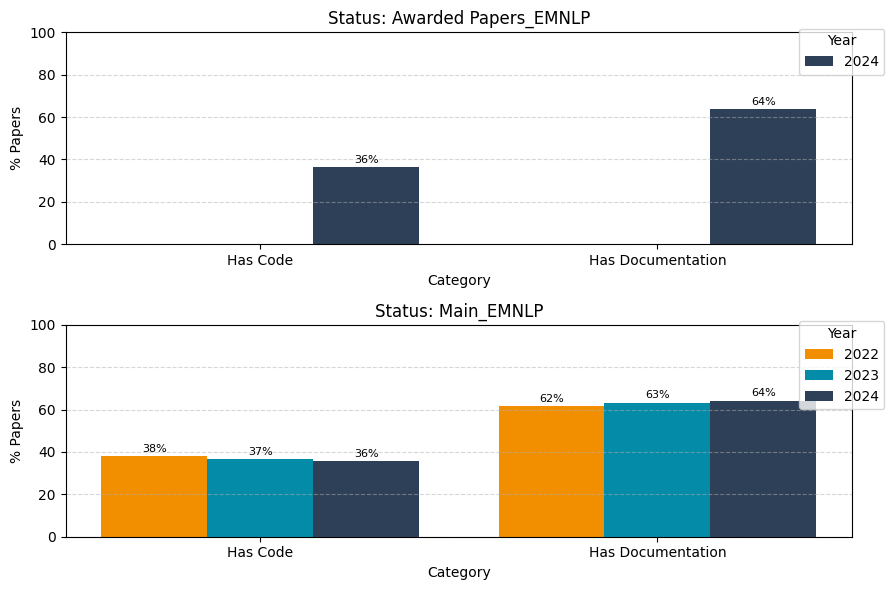

In [10]:
import json
import csv
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd

titles = {
    'rubric-0': "Sources",
    'rubric-1': "Data Annotations",
    'rubric-2': "Quality Assurance",
    'rubric-3': "Data Novelty",
    'rubric-4': "Task Utility",
    'rubric-5': "Language",
    'rubric-6': "Reproducibility"
}

def analyze_specific_rubric_trends(json_filepaths, csv_filepaths, conference_names, target_rubrics):
    """
    Analyzes trends for specific rubrics across multiple conferences,
    aggregating all categories except 'N/A' into an 'All Other Categories (OR)' group.

    Args:
        json_filepaths (list): A list of file paths to the JSON files, one for each conference.
        csv_filepaths (list): A list of file paths to the CSV files, one for each conference.
        conference_names (list): A list of names for each conference, corresponding to file paths.
        target_rubrics (list): A list of rubric IDs (e.g., ['rubric-1', 'rubric-2'])
                                for which to apply the specific aggregation logic.

    Returns:
        dict: A nested dictionary containing yearly counts for 'N/A' and
              'All Other Categories (OR)', grouped by conference name and then by target rubric ID.
              Structure: {conference_name: {rubric_id: {year: {'N/A': count, 'All Other Categories (OR)': count}}}}.
    """
    print(len(json_filepaths))
    if not (len(json_filepaths) == len(csv_filepaths) == len(conference_names)):
        print("Error: The lists of JSON file paths, CSV file paths, and conference names must be of the same length.")
        return {}

    all_conferences_rubric_data = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(int)))))

    for conf_idx, conf_name in enumerate(conference_names):
        json_filepath = json_filepaths[conf_idx]
        csv_filepath = csv_filepaths[conf_idx]

        print(f"Processing data for conference: {conf_name}")

        # Load the CSV content using pandas
        try:
            csv_df = pd.read_csv(csv_filepath)
            id_to_year = csv_df.set_index('id')['year'].astype(str).to_dict()
        except FileNotFoundError:
            print(f"Error: CSV file not found at {csv_filepath} for {conf_name}. Skipping this conference.")
            continue
        except KeyError:
            print(f"Error: 'id' or 'year' column not found in CSV file {csv_filepath} for {conf_name}. Skipping this conference.")
            continue
        except Exception as e:
            print(f"Error loading or processing CSV file {csv_filepath} for {conf_name}: {e}. Skipping this conference.")
            continue

        # Load the JSON content using json.load
        try:
            with open(json_filepath, 'r') as f:
                json_data = json.load(f)
        except FileNotFoundError:
            print(f"Error: JSON file not found at {json_filepath} for {conf_name}. Skipping this conference.")
            continue
        except json.JSONDecodeError:
            print(f"Error: Could not decode JSON from {json_filepath} for {conf_name}. Check file format. Skipping this conference.")
            continue
        except Exception as e:
            print(f"Error loading JSON file {json_filepath} for {conf_name}: {e}. Skipping this conference.")
            continue
        
        json_df = pd.DataFrame(json_data)
        # Extract the numeric part before the dash for join key
        json_df['base_id'] = json_df['id'].str.split('-').str[:-2].str.join('-')

        # Ensure csv_df's 'id' column is also string type to match
        csv_df['id'] = csv_df['id'].astype(str)
        
        # Perform the join on base_id from json_df and id from csv_df
        
        joined_df = pd.merge(json_df, csv_df, left_on='base_id', right_on='id', how='inner')

        # Drop the redundant key if needed (keeping the original 'id' from json_df)
        joined_df.drop(columns=['base_id', 'id_y'], inplace=True)
        joined_df.rename(columns={'id_x': 'id'}, inplace=True)

        # Convert back to JSON-style list of dicts
        json_data = joined_df.to_dict(orient='records')

        # Process data for the current conference
        for entry in json_data:
            full_json_id = entry.get('id')
            base_json_id = "-".join(full_json_id.split("-")[:-2])
            rubric_id = "-".join(full_json_id.split("-")[-2:])
            actual_conf_name = conf_name

            if actual_conf_name == "NLP":
                actual_conf_name = full_json_id.split("-")[0].upper()
                status = 'Main' if pd.isna(entry['award']) else 'Awarded Papers'
            else:
                if 'award' in entry:
                    # Entry just id and response, need to join with appropraite table
                    status = entry['award']
                elif 'status' in entry:
                    status = entry['status']
                else:
                    status = "Default"

            # Only process if the rubric_id is one of the target rubrics
            if rubric_id == "rubric-0" or rubric_id == "rubric-1" or rubric_id == "rubric-6":
                year = id_to_year.get(base_json_id)
                if year:
                    try:
                        year = int(year)
                    except ValueError:
                        continue
                    
                    response_data = entry.get('response', {})
                    if not response_data:
                        continue
                    
                    # if rubric_id == "rubric-1":
                    #     section_content = response_data["data_annotations"]
                    #     if len(section_content) == 0:
                    #         all_conferences_rubric_data[conf_name][rubric_id][year]["N/A"] += 1
                    #     else:
                    #         for content in section_content:
                    #             found_guidelines = False
                    #             if "Automatic Process" != content["Subject Annotators"]:
                    #                 for key in content:
                    #                     if key != "Subject Annotators" and content[key]["is_applicable"]:
                    #                         found_guidelines = True 
                    #                         all_conferences_rubric_data[conf_name][rubric_id][year][key] += 1
                                        
                    #                 if not found_guidelines:
                    #                     all_conferences_rubric_data[conf_name][rubric_id][year]["N/A"] += 1
                    
                    
                    if rubric_id == "rubric-0":
                        section_content = response_data["sources"]
                        for content in section_content:
                            all_conferences_rubric_data[actual_conf_name][rubric_id][year][status][content['Modality']] += 1

                    elif rubric_id == "rubric-1":
                        section_content = response_data["data_annotations"]
                        if len(section_content) == 0:
                            all_conferences_rubric_data[actual_conf_name][rubric_id][year][status]["N/A"] += 1
                        else:
                            for content in section_content:
                                found_guidelines = False
                                if "Automatic Process" != content["Subject Annotators"]:
                                    for key in content:
                                        if key != "Subject Annotators" and content[key]["is_applicable"]:
                                            found_guidelines = True 
                                            all_conferences_rubric_data[actual_conf_name][rubric_id][year][status][key] += 1
                                        
                                    if not found_guidelines:
                                        all_conferences_rubric_data[actual_conf_name][rubric_id][year][status]["No Guidelines"] += 1
                                        
                    elif rubric_id == "rubric-6":
                        section_content = response_data["reproducibility"]
                        if section_content["code"]["Has Code"]:
                            all_conferences_rubric_data[actual_conf_name][rubric_id][year][status]["Has Code"] += 1
                        if section_content["documentation"]["Has Documentation"]:
                            all_conferences_rubric_data[actual_conf_name][rubric_id][year][status]["Has Documentation"] += 1
                                        
            elif rubric_id in target_rubrics:
                year = id_to_year.get(base_json_id)
                if year:
                    try:
                        year = int(year)
                    except ValueError:
                        continue

                    response_data = entry.get('response', {})
                    if not response_data:
                        continue

                    for section_name, section_content in response_data.items():
                        if isinstance(section_content, dict):
                            for category_name, category_details in section_content.items():
                                if isinstance(category_details, dict) and 'is_applicable' in category_details:
                                    if category_details.get('is_applicable') is True:
                                        all_conferences_rubric_data[actual_conf_name][rubric_id][year][status][category_name] += 1
    
    return all_conferences_rubric_data

import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
import matplotlib.cm as cm

colors = ["#f18f01", "#048ba8", "#2e4057"]

# Combine these into the former
STATUS_MAPPING = {
    "Desk Reject": "Reject",
    "Top-5%": "Oral",
    "Top-25%": "Spotlight",
    "Highlighted": "Spotlight",
}

def normalize_status(status):
    return STATUS_MAPPING.get(status, status)

def plot_per_conference_by_category(all_conferences_rubric_data, target_rubrics):
    if not all_conferences_rubric_data:
        print("No data available.")
        return

    all_conferences = list(all_conferences_rubric_data.keys())

    status_mapping = {
        "Desk Reject": "Reject",
        "Top-5%": "Oral",
        "Top-25%": "Spotlight",
        "Highlighted": "Spotlight",
    }

    for rubric_id in target_rubrics:
        for conf_name in all_conferences:
            conf_data_raw = all_conferences_rubric_data[conf_name].get(rubric_id)
            if not conf_data_raw:
                print(f"No data for rubric {rubric_id} in {conf_name}. Skipping.")
                continue

            # Normalize statuses
            conf_data = {}
            for year, status_dict in conf_data_raw.items():
                for status, modality_dict in status_dict.items():
                    mapped_status = status_mapping.get(status, status)
                    conf_data.setdefault(year, {}).setdefault(mapped_status, {})
                    for modality, count in modality_dict.items():
                        conf_data[year][mapped_status][modality] = (
                            conf_data[year][mapped_status].get(modality, 0) + count
                        )

            all_years = sorted(conf_data.keys())
            all_statuses = set()
            for year in all_years:
                all_statuses.update(conf_data[year].keys())
                
            if len(all_statuses) > 1:
                num_statuses = len(all_statuses)
                fig, axes = plt.subplots(num_statuses, 1, figsize=(max(2.7, len(conf_data) * 1.5) * num_statuses, 3 * num_statuses), sharex=True)
                if num_statuses == 1:
                    axes = [axes]
                for ax, status in zip(axes, sorted(all_statuses)):
                    status_data = {year: conf_data[year].get(status, {}) for year in all_years}
                    all_categories = set()
                    for year_dict in status_data.values():
                        all_categories.update(year_dict.keys())
                    all_categories = sorted(all_categories)

                    year_colors = {
                        year: colors[i % len(colors)]
                        for i, year in enumerate(all_years)
                    }

                    num_years = len(all_years)
                    group_width = 0.8
                    bar_width = group_width / num_years

                    x_positions = []
                    x_labels = []

                    for cat_idx, category in enumerate(all_categories):
                        for year_idx, year in enumerate(all_years):
                            year_dict = status_data.get(year, {})
                            count = year_dict.get(category, 0)
                            total = sum(year_dict.values())
                            if total == 0:
                                continue

                            pct = count / total * 100
                            x_base = cat_idx
                            bar_offset = (year_idx - (num_years - 1) / 2) * bar_width
                            bar_pos = x_base + bar_offset + 0.5

                            ax.bar(
                                bar_pos, pct, bar_width,
                                color=year_colors[year],
                                label=str(year) if cat_idx == 0 else ""
                            )

                            if pct > 0:
                                ax.text(bar_pos, pct + 1, f"{pct:.0f}%", ha='center', va='bottom', fontsize=8)

                        x_positions.append(cat_idx + 0.5)
                        label = category.replace("(", "\n(").replace("/", "\n/\n").replace(" and ", "\nand\n")
                        x_labels.append(label)

                    ax.tick_params(labelbottom=True)
                    ax.set_xticks(x_positions)
                    ax.set_xticklabels(x_labels)
                    ax.set_ylim(0, 100)
                    ax.set_title(f"Status: {status}_{conf_name}")
                    ax.set_ylabel('% Papers')
                    ax.set_xlabel('Category')
                    ax.grid(axis='y', linestyle='--', alpha=0.5)

                    handles, labels = ax.get_legend_handles_labels()
                    unique = dict(zip(labels, handles))
                    ax.legend(unique.values(), unique.keys(), title="Year", loc='upper right', bbox_to_anchor=(1.05, 1.05))

                # plt.suptitle(f'{conf_name} — Category Trends for Rubric {rubric_id}')
                plt.tight_layout()
                plt.show()

            # else:
            #     status = next(iter(all_statuses))
            #     status_data = {year: conf_data[year].get(status, {}) for year in all_years}
            #     all_categories = set()
            #     for year_dict in status_data.values():
            #         all_categories.update(year_dict.keys())
            #     all_categories = sorted(all_categories)

            #     year_colors = {
            #         year: colors[i % len(colors)]
            #         for i, year in enumerate(all_years)
            #     }

            #     fig, ax = plt.subplots(figsize=(max(2.7, len(all_categories) * 1.5), 3))
            #     num_years = len(all_years)
            #     group_width = 0.8
            #     bar_width = group_width / num_years

            #     x_positions = []
            #     x_labels = []

            #     for cat_idx, category in enumerate(all_categories):
            #         for year_idx, year in enumerate(all_years):
            #             year_dict = status_data.get(year, {})
            #             count = year_dict.get(category, 0)
            #             total = sum(year_dict.values())
            #             if total == 0:
            #                 continue

            #             pct = count / total * 100
            #             x_base = cat_idx
            #             bar_offset = (year_idx - (num_years - 1) / 2) * bar_width
            #             bar_pos = x_base + bar_offset + 0.5

            #             ax.bar(
            #                 bar_pos, pct, bar_width,
            #                 color=year_colors[year],
            #                 label=str(year) if cat_idx == 0 else ""
            #             )

            #             if pct > 0:
            #                 ax.text(bar_pos, pct + 1, f"{pct:.0f}%", ha='center', va='bottom', fontsize=8)

            #         x_positions.append(cat_idx + 0.5)
            #         label = category.replace("(", "\n(").replace("/", "\n/\n").replace(" and ", "\nand\n")
            #         x_labels.append(label)

            #     ax.set_xticks(x_positions)
            #     ax.set_xticklabels(x_labels)
            #     ax.set_ylim(0, 100)
            #     # ax.set_title(f'{conf_name} — Category Trends for Rubric {rubric_id}')
            #     ax.set_ylabel('% Papers')
            #     ax.set_xlabel('Category')
            #     ax.grid(axis='y', linestyle='--', alpha=0.5)

            #     handles, labels = ax.get_legend_handles_labels()
            #     unique = dict(zip(labels, handles))
            #     ax.legend(unique.values(), unique.keys(), title="Year", loc='upper right', bbox_to_anchor=(1.05, 1.05))

            #     plt.tight_layout()
            #     plt.show()

# Example Usage:
# json_file_path = 'neurips_qwen3_32b_full.json'
# csv_file_path = 'filtered_year_neurips_conference.csv'
# target_rubrics_to_plot = ['rubric-1', 'rubric-2'] # Specify the rubrics you want to plot with this aggregation

# 1. Analyze the data with specific aggregation
# aggregated_trends = analyze_specific_rubric_trends(json_file_path, csv_file_path, target_rubrics_to_plot)

# 2. Plot the trends for the specified rubrics
# plot_specific_rubric_trends(aggregated_trends)

target_rubrics_to_plot = ['rubric-0', 'rubric-1', 'rubric-2', 'rubric-3', 'rubric-4', 'rubric-5', 'rubric-6']

json_file_paths = ['../data/rubric_gen_results/gpt41mini_result_neurips.json',
                   '../data/rubric_gen_results/gpt41mini_result_iclr.json',
                   '../data/rubric_gen_results/gpt41mini_result_icml.json',
                   '../data/rubric_gen_results/gpt41mini_result_nlp.json',
                   '../data/rubric_gen_results/gpt41mini_result_cv.json',
                   '../data/rubric_gen_results/gpt41mini_result_interspeech.json']
csv_file_paths = ['../data/csv/sampled_filtered_year_neurips_papers.csv', 
                  '../data/csv/sampled_filtered_year_iclr_papers.csv',
                  '../data/csv/sampled_filtered_year_icml_papers.csv',
                  '../data/csv/sampled_filtered_year_nlp_papers.csv', 
                  '../data/csv/sampled_filtered_year_cv_papers.csv',
                  '../data/csv/sampled_filtered_year_interspeech_papers.csv']

conference_names = ['NeurIPS', 'ICLR', 'ICML', 'NLP', 'CV', 'InterSpeech']

aggregated_trends = analyze_specific_rubric_trends(json_file_paths, csv_file_paths, conference_names, target_rubrics_to_plot)

print(aggregated_trends)
plot_per_conference_by_category(aggregated_trends, target_rubrics_to_plot)

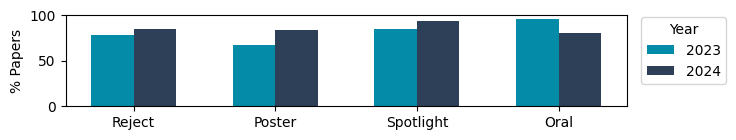

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Categories
categories = ['Reject', 'Poster', 'Spotlight', 'Oral']
x = np.arange(len(categories))  # the label locations

# Data for each group
model_a = [0, 35, 21, 0]
model_b = [22, 33, 15, 4]
model_c = [15, 16, 6, 19]
# model_a = [100-x if x > 0 else 0 for x in model_a]
model_b = [100-x if x > 0 else 0 for x in model_b]
model_c = [100-x if x > 0 else 0 for x in model_c]
colors = ["#f18f01", "#048ba8", "#2e4057"]

width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize=(7.5, 1.5))
# bars1 = ax.bar(x - width*4/4, model_a, width, label='2022', color=colors[0])
bars2 = ax.bar(x - width/2, model_b, width, label='2023', color=colors[1])
bars3 = ax.bar(x + width*1/2, model_c, width, label='2024', color=colors[2])

# Add some text and formatting
# ax.set_xlabel('Categories')
ax.set_ylabel('% Papers')
# ax.set_title('No Guidelines')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend(title="Year", loc='upper right', bbox_to_anchor=(1.19, 1.05))

plt.tight_layout()
plt.savefig(f"plots/neurips_categories_data_annotations_guidelines.png", dpi=300) 

plt.show()

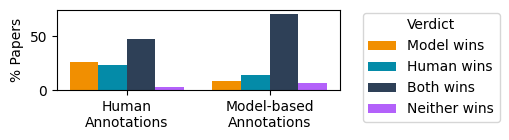

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Categories
categories = ['Human\nAnnotations', 'Model-based\nAnnotations']
x = np.arange(len(categories))  # the label locations

# Data for each group
model_a = [26, 8]
model_b = [23, 14]
model_c = [48, 71]
model_d = [3, 7]
colors = ["#f18f01", "#048ba8", "#2e4057", "#b361fa"]

width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(6.5, 1.5))
bars1 = ax.bar(x - width*6/4, model_a, width, label='Model wins', color=colors[0])
bars2 = ax.bar(x - width/2, model_b, width, label='Human wins', color=colors[1])
bars3 = ax.bar(x + width/2, model_c, width, label='Both wins', color=colors[2])
bars4 = ax.bar(x + width*6/4, model_d, width, label='Neither wins', color=colors[3])

# Add some text and formatting
# ax.set_xlabel('Categories')
ax.set_ylabel('% Papers')
# ax.set_title('No Guidelines')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend(title="Verdict", loc='upper right', bbox_to_anchor=(1.59, 1.05))

plt.tight_layout()
plt.savefig(f"plots/human_vs_model.png", dpi=300) 

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Categories
categories = ['ACL', 'CVPR', 'EMNLP', 'ICLR', 'ICML', 'Interspeech', 'LREC', 'NeurIPS']
x = np.arange(len(categories))  # the label locations

# Data for each group
model_a = [10, 78, 7, 28, 16, 50, 14, 32]
model_b = [8, 85, 10, 19, 20, 54, 0, 25]
model_c = [6, 74, 6, 13, 15, 39, 16, 11]
model_a = [100-x if x > 0 else 0 for x in model_a]
model_b = [100-x if x > 0 else 0 for x in model_b]
model_c = [100-x if x > 0 else 0 for x in model_c]
colors = ["#f18f01", "#048ba8", "#2e4057"]

width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize=(7.5, 1.5))
bars1 = ax.bar(x - width*4/4, model_a, width, label='2022', color=colors[0])
bars2 = ax.bar(x, model_b, width, label='2023', color=colors[1])
bars3 = ax.bar(x + width*4/4, model_c, width, label='2024', color=colors[2])

# Add some text and formatting
# ax.set_xlabel('Categories')
ax.set_ylabel('% Papers')
# ax.set_title('No Guidelines')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend(title="Year", loc='upper right', bbox_to_anchor=(1.19, 1.05))

plt.tight_layout()
plt.savefig(f"plots/guidelines.png", dpi=300) 

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Categories
categories = ['ACL', 'CVPR', 'EMNLP', 'ICLR', 'ICML', 'Interspeech', 'LREC', 'NeurIPS']
x = np.arange(len(categories))  # the label locations

# Data for each group
model_a = [10, 78, 7, 28, 16, 50, 14, 32]
model_b = [8, 85, 10, 19, 20, 54, 0, 25]
model_c = [6, 74, 6, 13, 15, 39, 16, 11]
model_a = [100-x if x > 0 else 0 for x in model_a]
model_b = [100-x if x > 0 else 0 for x in model_b]
model_c = [100-x if x > 0 else 0 for x in model_c]
colors = ["#f18f01", "#048ba8", "#2e4057"]

width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize=(7.5, 1.5))
bars1 = ax.bar(x - width*4/4, model_a, width, label='2022', color=colors[0])
bars2 = ax.bar(x, model_b, width, label='2023', color=colors[1])
bars3 = ax.bar(x + width*4/4, model_c, width, label='2024', color=colors[2])

# Add some text and formatting
# ax.set_xlabel('Categories')
ax.set_ylabel('% Papers')
# ax.set_title('No Guidelines')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend(title="Year", loc='upper right', bbox_to_anchor=(1.19, 1.05))

plt.tight_layout()
plt.savefig(f"plots/guidelines.png", dpi=300) 

plt.show()

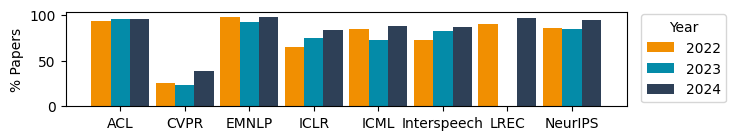

In [141]:
import matplotlib.pyplot as plt
import numpy as np

# Categories
categories = ['ACL', 'CVPR', 'EMNLP', 'ICLR', 'ICML', 'Interspeech', 'LREC', 'NeurIPS']
x = np.arange(len(categories))  # the label locations

# Data for each group
model_a = [7, 74, 2, 35, 15, 27, 10, 14]
model_b = [5, 77, 8, 25, 27, 18, 0, 15]
model_c = [4, 61, 2, 17, 12, 13, 3, 6]
model_a = [100-x if x > 0 else 0 for x in model_a]
model_b = [100-x if x > 0 else 0 for x in model_b]
model_c = [100-x if x > 0 else 0 for x in model_c]
colors = ["#f18f01", "#048ba8", "#2e4057"]

width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize=(7.5, 1.5))
bars1 = ax.bar(x - width*4/4, model_a, width, label='2022', color=colors[0])
bars2 = ax.bar(x, model_b, width, label='2023', color=colors[1])
bars3 = ax.bar(x + width*4/4, model_c, width, label='2024', color=colors[2])

# Add some text and formatting
# ax.set_xlabel('Categories')
ax.set_ylabel('% Papers')
# ax.set_title('No Guidelines')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend(title="Year", loc='upper right', bbox_to_anchor=(1.19, 1.05))

plt.tight_layout()
plt.savefig(f"plots/quality_assurance.png", dpi=300) 

plt.show()

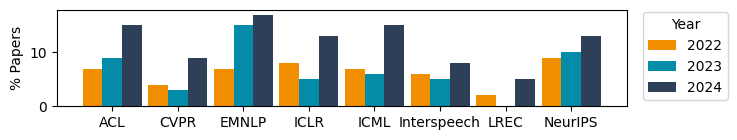

In [192]:
import matplotlib.pyplot as plt
import numpy as np

# Categories
categories = ['ACL', 'CVPR', 'EMNLP', 'ICLR', 'ICML', 'Interspeech', 'LREC', 'NeurIPS']
x = np.arange(len(categories))  # the label locations

# Data for each group
model_a = [7, 4, 7, 8, 7, 6, 2, 9]
model_b = [9, 3, 15, 5, 6, 5, 0, 10]
model_c = [15, 9, 17, 13, 15, 8, 5, 13]
colors = ["#f18f01", "#048ba8", "#2e4057"]

width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize=(7.5, 1.5))
bars1 = ax.bar(x - width*4/4, model_a, width, label='2022', color=colors[0])
bars2 = ax.bar(x, model_b, width, label='2023', color=colors[1])
bars3 = ax.bar(x + width*4/4, model_c, width, label='2024', color=colors[2])

# Add some text and formatting
# ax.set_xlabel('Categories')
ax.set_ylabel('% Papers')
# ax.set_title('No Guidelines')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend(title="Year", loc='upper right', bbox_to_anchor=(1.19, 1.05))

plt.tight_layout()
plt.savefig(f"plots/new_data_from_model.png", dpi=300) 

plt.show()